<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/SetFit_Nov30_SJ_R2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get necessary packages

In [3]:
#!pip install setfit
!pip install datasets
!pip install setfit[optuna] matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.7 MB/s 
     |████████████████████████████████| 212 kB 88.2 MB/s 
     |████████████████████████████████| 115 kB 94.3 MB/s 
     |████████████████████████████████| 182 kB 91.5 MB/s 
     |████████████████████████████████| 127 kB 94.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.9 MB/s 
     |████████████████████████████████| 362 kB 25.3 MB/s 
     |████████████████████████████████| 85 kB 6.3 MB/s 
     |████████████████████████████████| 348 kB 73.0 MB/s 
     |████████████████████████████████| 95 kB 5.9 MB/s 
     |████████████████████████████████| 5.5 MB 96.2 MB/s 
     |██████

In [4]:
!pip install empath
from empath import Empath
lexicon = Empath()
# Import module
!pip install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('punkt')
import collections
from collections import Counter
import spacy
nlp =spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 2.9 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57822 sha256=6c6c417fbf8fe906bf6472527b3a2ea1e9aa19bcff8a83fa9727a7c234829317
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 396 kB 4.6 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=6e0f91c637fd5219b9b28fe308dc6a8cae92cd0d790d89dd21d5a39e1faa2ba7
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import pandas as pd
import os, re
import time
import numpy as np
import pandas as pd
import io
from io import BytesIO
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,recall_score, precision_score, f1_score,matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset


In [6]:
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss

# Set Up gcp connectivity

In [7]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Dec  1 18:35:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    50W / 400W |    658MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
! ls -lrt /content/drive/MyDrive/*.json

-rw------- 1 root root 2308 Oct 13 00:53 /content/drive/MyDrive/nlpproject.json
-rw------- 1 root root 2326 Oct 31 03:37 /content/drive/MyDrive/pacific-castle-360400-a3ca89f64de6.json


In [9]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/drive/MyDrive/pacific-castle-360400-a3ca89f64de6.json' 
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/drive/MyDrive/pacific-castle-360400-a3ca89f64de6.json


In [10]:
from google.cloud import storage

storage_client = storage.Client()

buckets = storage_client.list_buckets()

print('-- List of buckets in project \"' + storage_client.project + '\"')

for b in buckets:
  print(b.name)

-- List of buckets in project "pacific-castle-360400"
266csffile
w266liwc


In [11]:
#Initialize google storage
#storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')

#Print buckets available
for bucket in storage_client.list_buckets():
  print(bucket)

#Assign bucket name being used
bucket_name = '266csffile'
#bucket_name = 'w266liwc'

#Get bucket
bucket = storage_client.get_bucket(bucket_name)

# #Show list of files in bucket and list the files
# filelist = list(bucket.list_blobs(prefix=''))
# for name in filelist:
#   print(name.name)

<Bucket: 266csffile>
<Bucket: w266liwc>


In [12]:
def read_parquet_google_cloud(file):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Load Google Cloud storage client using service key

    blob = bucket.blob(file)
    read_back = bucket.blob(file)
    string_read_back = read_back.download_as_string()
    new_df = pd.read_parquet(io.BytesIO(string_read_back))

    return new_df

In [ ]:
# def add_features(df):
  
#   df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
#   df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
#   df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
  
#   df['combined'] = df['Username'].astype(str)+" [SEP] " + df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"lexical categories: "+df['lexicon'].astype(str)+ " [SEP] "+"emotion scores: "+df['emotions'].astype(str)+" [SEP] " + "pos tags: "+df['postags'].astype(str)+ " [SEP] " + df['message'].astype(str)
#   return df


# Connect to hugging face

In [28]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


#Load data, set up datasets & feature engineering

In [ ]:
#load training and test data
#training 
train_mbti_data = read_parquet_google_cloud('train_uniform_mbti_data.parquet')
train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message']]


In [13]:
#test 
test_mbti_data = read_parquet_google_cloud('test_mbti_data.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')
test_mbti_data = test_mbti_data[['Username','Age','Posts','Occupation','message']]

In [106]:
train_mbti_data.count()

Username      1200000
Age           1200000
Posts         1200000
Occupation     623662
message       1200000
dtype: int64

In [14]:
#Create dictonary to transform MBTI type into multiclass value from 0 to 15
valid_MBTI = {'ISTJ': 0, 'INTJ': 1, 'ESTJ': 2, 'ENTJ': 3, 'ENTP': 4, 'INTP': 5, \
              'ISTP': 6, 'ESTP': 7, 'ISFJ': 8, 'INFJ': 9, 'ESFJ': 10, \
              'ENFJ': 11, 'ENFP': 12, 'INFP': 13, 'ISFP': 14, 'ESFP': 15}

In [108]:
#get data and labels data together 
train_combined = pd.concat([train_mbti_data,train_mbti_labels],axis=1)


In [15]:
test_combined = pd.concat([test_mbti_data,test_mbti_labels],axis=1)

In [109]:
#map the labels to a valid class
train_combined['label']= train_combined['MBTI Type'].map(valid_MBTI)


In [16]:
test_combined['label']= test_combined['MBTI Type'].map(valid_MBTI)

In [17]:
test_combined

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label
1400000,laurie,49.0,6072,nada,i liked it.,852132,ENFP,12
1400001,searchingforpeace,52.0,5569,None,nope just why?,1242759,ENFJ,11
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",61435,INTP,5
1400003,eric b,56.0,3620,subway motorman,^ i think so too!! tyrion and brienne are both...,437446,INTP,5
1400004,yama,28.0,7684,microbiology technician,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,1589900,ESFJ,10
...,...,...,...,...,...,...,...,...
1493101,coriolis,45.0,26905,None,"a lot of things because me feel guilty, even t...",283920,INTJ,1
1493102,uumlau,56.0,5517,None,you are so cute. yes you can blow an extraor...,1525910,INTJ,1
1493103,betty blue,45.0,5064,self employed,"vacuumed the whole house, ran greatest distanc...",144864,ENFP,12
1493104,jeffster,46.0,6743,office manager for subway (eat fresh!),XXXXc ^?,715585,ESFP,15


In [111]:
t_dataset = Dataset.from_pandas(train_combined)

In [112]:
t_dataset

Dataset({
    features: ['Username', 'Age', 'Posts', 'Occupation', 'message', 'original index', 'MBTI Type', 'label'],
    num_rows: 1200000
})

In [113]:
# Create samples for SetFit Training
seed=20
labels = 16
samples_per_label = 32
sampled_datasets = []
# find the number of samples per label
for i in range(labels):
    sampled_datasets.append(t_dataset.filter(lambda x: x["label"] == i).shuffle(seed=seed).select(range(samples_per_label)))



  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

In [114]:
# concatenate the sampled datasets
from datasets import concatenate_datasets
train_dataset = concatenate_datasets(sampled_datasets)

In [115]:
train_dataset

Dataset({
    features: ['Username', 'Age', 'Posts', 'Occupation', 'message', 'original index', 'MBTI Type', 'label'],
    num_rows: 512
})

In [18]:
# create test dataset
test_dataset = Dataset.from_pandas(test_combined)

In [19]:
test_dataset

Dataset({
    features: ['Username', 'Age', 'Posts', 'Occupation', 'message', 'original index', 'MBTI Type', 'label'],
    num_rows: 93106
})

In [20]:
test_dataset[0]

{'Username': 'laurie',
 'Age': 49.0,
 'Posts': 6072,
 'Occupation': 'nada',
 'message': 'i liked it.',
 'original index': 852132,
 'MBTI Type': 'ENFP',
 'label': 12}

In [121]:
train_dataset

Dataset({
    features: ['Username', 'Age', 'Posts', 'Occupation', 'message', 'original index', 'MBTI Type', 'label'],
    num_rows: 512
})

## Feature Enginnering Train and Test

In [128]:
#Training feature engineering
train_dataset = train_dataset.map(lambda example:{'message': example['Username']+' SEP '+
                                                    str(example['Age'])+' SEP '+
                                                    str(example['Posts'])+' SEP '+
                                                    str(example['Occupation'])+' SEP '+
                                                    ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(example['message']).items() if value > 0) + ' SEP ' +
                                                    ', '.join(f'{key} {str(value)}' for key, value in NRCLex(example['message']).raw_emotion_scores.items() if value > 0) + ' SEP ' +
                                                    ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(example['message']))).items()) +' SEP ' +
                                                    example['message']})

  0%|          | 0/512 [00:00<?, ?ex/s]

In [21]:
test_dataset = test_dataset.map(lambda example:{'message': example['Username']+' SEP '+
                                                    str(example['Age'])+' SEP '+
                                                    str(example['Posts'])+' SEP '+
                                                    str(example['Occupation'])+' SEP '+
                                                    ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(example['message']).items() if value > 0) + ' SEP ' +
                                                    ', '.join(f'{key} {str(value)}' for key, value in NRCLex(example['message']).raw_emotion_scores.items() if value > 0) + ' SEP ' +
                                                    ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(example['message']))).items()) +' SEP ' +
                                                    example['message']})

  0%|          | 0/93106 [00:00<?, ?ex/s]

In [131]:
train_dataset = train_dataset.remove_columns(["Username",'Age','Posts','Occupation','original index','MBTI Type'])

In [23]:
test_dataset = test_dataset.remove_columns(["Username",'Age','Posts','Occupation','original index','MBTI Type'])

In [24]:
test_dataset[99]

{'message': 'uumlau SEP 56.0 SEP 5517 SEP None SEP play 1.0 SEP negative 1 SEP intj 1, punct 6, noun 7, verb 3, pron 5, adj 3, space 2, num 3, adp 2, det 2, cconj 1, aux 2, adv 1 SEP hah, yer doing it wrong.  i have two tattoos, one of a tarot card and one squid like tribal flamey thing.  have you ever had a nickname, what was it?',
 'label': 1}

#Multiclass classification using SetFit models with feature enginnering

In [137]:
#run with feature engineering
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss

# Load a SetFit model from Hub
model_id = "sentence-transformers/all-mpnet-base-v2"
model = SetFitModel.from_pretrained(model_id)

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
    column_mapping={"message": "text", "label": "label"},
)

# Train and evaluate
trainer.train()
metrics = trainer.evaluate()

print(f"model used: {model_id}")
print(f"train dataset: {len(train_dataset)} samples")
print(f"accuracy: {metrics['accuracy']}")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 1
  Total optimization steps = 1280
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


model used: sentence-transformers/all-mpnet-base-v2
train dataset: 512 samples
accuracy: 0.606867441410865


In [139]:
trainer.push_to_hub(f"setfit-mbti-multiclass-w266_Nov29")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'push_to_hub': pass repo_path_or_name='setfit-mbti-multiclass-w266_Nov29', repo_url=None, commit_message='Add SetFit model', organization=None, private=None, api_endpoint=None, token=None, git_user=None, git_email=None, config=None, skip_lfs_files=False as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'push_to_hub': repo_path_or_name. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Cloning https://huggingface.co/shrinivasbjoshi/setfit-mbti-multiclass-w266_Nov29 into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/418M [00:00<?, ?B/s]

Upload file model_head.pkl:   3%|3         | 3.34k/97.2k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/shrinivasbjoshi/setfit-mbti-multiclass-w266_Nov29
   fd3fc0a..5c0be82  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/shrinivasbjoshi/setfit-mbti-multiclass-w266_Nov29
   fd3fc0a..5c0be82  main -> main



'https://huggingface.co/shrinivasbjoshi/setfit-mbti-multiclass-w266_Nov29/commit/5c0be823d6989cd68b186567c20eff4276dc3e96'

In [140]:
w266_setfit_mbti = SetFitModel.from_pretrained("shrinivasbjoshi/setfit-mbti-multiclass-w266_Nov29")

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

              precision    recall  f1-score   support

        ISTJ       0.70      0.66      0.68      1877
        INTJ       0.66      0.59      0.62     12850
        ESTJ       0.96      0.90      0.93      2243
        ENTJ       0.53      0.68      0.59      4186
        ENTP       0.57      0.51      0.54      8567
        INTP       0.67      0.51      0.58     12925
        ISTP       0.38      0.69      0.49      3576
        ESTP       0.65      0.88      0.75      1840
        ISFJ       0.30      0.85      0.44      1061
        INFJ       0.40      0.62      0.49      9275
        ESFJ       0.95      0.93      0.94      2169
        ENFJ       0.89      0.78      0.83      2920
        ENFP       0.78      0.58      0.67     11048
        INFP       0.52      0.41      0.46     12497
        ISFP       0.97      0.88      0.92      3946
        ESFP       0.86      0.89      0.87      2126

    accuracy                           0.61     93106
   macro avg       0.67   

Text(159.0, 0.5, 'True')

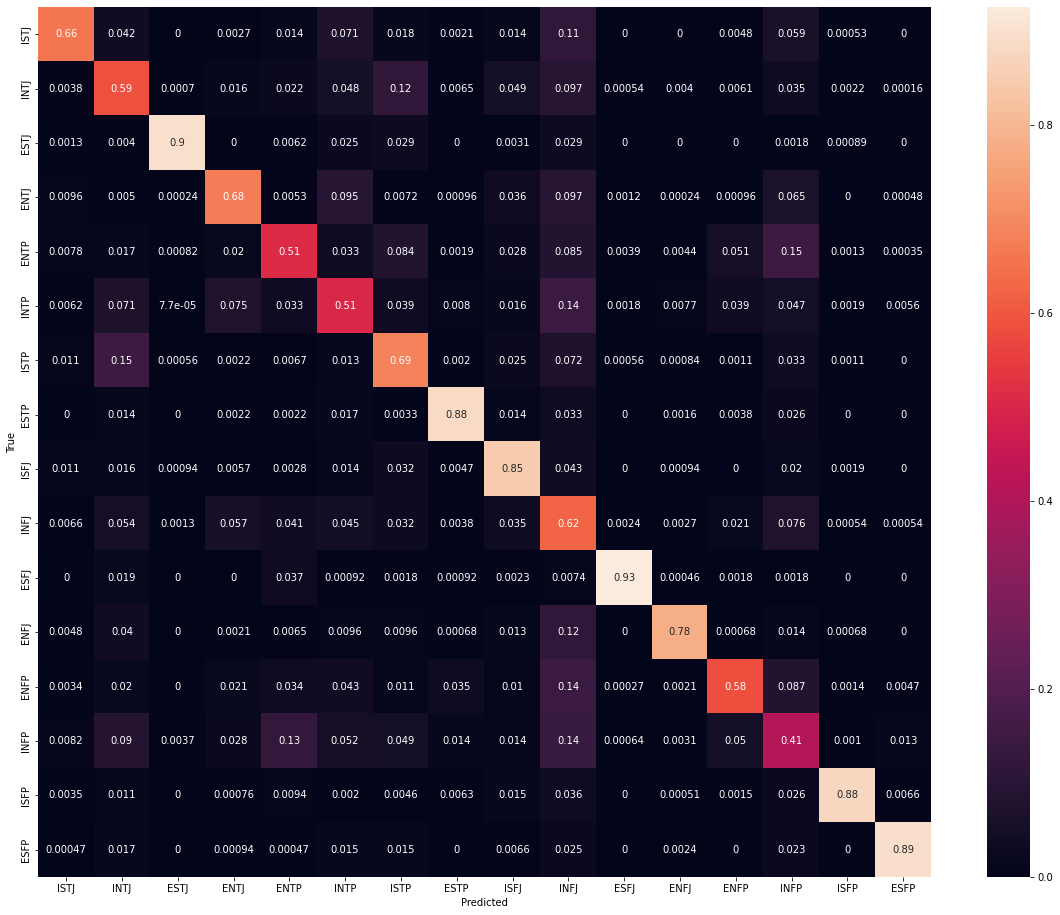

In [154]:
input = test_dataset['message']
predictions = w266_setfit_mbti.predict(input)
test_labels = test_dataset['label']
nptest_labels = np.asarray(test_labels)
multiclass_predictions = predictions
print(classification_report(nptest_labels, multiclass_predictions,target_names=valid_MBTI))
cr_multi = classification_report(nptest_labels, multiclass_predictions, target_names=valid_MBTI)

cm_multi = confusion_matrix(nptest_labels, multiclass_predictions)
cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(20,16))
sns.heatmap(
      cm_multi, annot=True,
      xticklabels=valid_MBTI,
      yticklabels=valid_MBTI)
plt.xlabel("Predicted")
plt.ylabel("True")

#Hyperparameter Search with feature engineering

## Set the model

In [160]:


# model specfic hyperparameters
def model_init(params):
    params = params or {}
    max_iter = params.get("max_iter", 10) #10 iterations
    solver = params.get("solver", "liblinear")
    model_id = params.get("model_id", "sentence-transformers/all-mpnet-base-v2")
    model_params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained(model_id, **model_params)

# training hyperparameters
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 2),
        "batch_size": trial.suggest_categorical("batch_size", [4, 8, 16]),
        "num_iterations": trial.suggest_categorical("num_iterations", [10, 20]),
        "seed": trial.suggest_int("seed", 1, 40),
        "max_iter": trial.suggest_int("max_iter", 50, 100),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
        "model_id": trial.suggest_categorical(
            "model_id",
            [
                "sentence-transformers/all-mpnet-base-v2",
            ],
        ),
    }





## Set the hyper parameter trainer

In [163]:
hyp_trainer = SetFitTrainer(
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    model_init=model_init,
    column_mapping={"message": "text", "label": "label"},
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


## Run the hyperparameter search

In [165]:
best_run = hyp_trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=10)

[I 2022-11-30 03:52:47,942] A new study created in memory with name: no-name-e4295e34-0d2b-483d-bad5-a77c64a1b8d2
Trial: {'learning_rate': 9.46667947923119e-05, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 20, 'seed': 8, 'max_iter': 95, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 2
  Total optimization steps = 5120
  Total train batch size = 8


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 04:46:38,699] Trial 0 finished with value: 0.6816961312912164 and parameters: {'learning_rate': 9.46667947923119e-05, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 20, 'seed': 8, 'max_iter': 95, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.
Trial: {'learning_rate': 4.660449126254091e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20, 'seed': 9, 'max_iter': 74, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 2
  Total optimization steps = 2560
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 05:38:24,941] Trial 1 finished with value: 0.6712993792021996 and parameters: {'learning_rate': 4.660449126254091e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20, 'seed': 9, 'max_iter': 74, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.
Trial: {'learning_rate': 2.820360303246863e-05, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 10, 'seed': 36, 'max_iter': 56, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 10240
  Num epochs = 2
  Total optimization steps = 2560
  Total train batch size = 8


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 06:07:41,135] Trial 2 finished with value: 0.6631258995123838 and parameters: {'learning_rate': 2.820360303246863e-05, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 10, 'seed': 36, 'max_iter': 56, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.
Trial: {'learning_rate': 5.196129276747898e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 10, 'seed': 3, 'max_iter': 58, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not foun

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 06:18:28,227] Trial 3 finished with value: 0.48546817605739695 and parameters: {'learning_rate': 5.196129276747898e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 10, 'seed': 3, 'max_iter': 58, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.
Trial: {'learning_rate': 1.3481781912692843e-06, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 10, 'seed': 3, 'max_iter': 88, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found 

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/640 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 06:29:00,137] Trial 4 finished with value: 0.4986359633106352 and parameters: {'learning_rate': 1.3481781912692843e-06, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 10, 'seed': 3, 'max_iter': 88, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.
Trial: {'learning_rate': 1.0643682153735296e-05, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 10, 'seed': 27, 'max_iter': 75, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 10240
  Num epochs = 1
  Total optimization steps = 640
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/640 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 06:39:31,976] Trial 5 finished with value: 0.518731338474427 and parameters: {'learning_rate': 1.0643682153735296e-05, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 10, 'seed': 27, 'max_iter': 75, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.
Trial: {'learning_rate': 8.555710416119671e-06, 'num_epochs': 2, 'batch_size': 4, 'num_iterations': 20, 'seed': 5, 'max_iter': 97, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 2
  Total optimization steps = 10240
  Total train batch size = 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10240 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 07:38:45,468] Trial 6 finished with value: 0.661955190857732 and parameters: {'learning_rate': 8.555710416119671e-06, 'num_epochs': 2, 'batch_size': 4, 'num_iterations': 20, 'seed': 5, 'max_iter': 97, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.
Trial: {'learning_rate': 1.8818583228829615e-06, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 20, 'seed': 26, 'max_iter': 72, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not fou

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 07:55:13,557] Trial 7 finished with value: 0.5203316649839967 and parameters: {'learning_rate': 1.8818583228829615e-06, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 20, 'seed': 26, 'max_iter': 72, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.
Trial: {'learning_rate': 1.1361617044744673e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20, 'seed': 18, 'max_iter': 63, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not fou

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 08:46:59,704] Trial 8 finished with value: 0.6615792752346787 and parameters: {'learning_rate': 1.1361617044744673e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20, 'seed': 18, 'max_iter': 63, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.
Trial: {'learning_rate': 1.8489059926188168e-06, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 10, 'seed': 17, 'max_iter': 74, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 10240
  Num epochs = 2
  Total optimization steps = 2560
  Total train batch size = 8


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-11-30 09:16:17,337] Trial 9 finished with value: 0.4326788821343415 and parameters: {'learning_rate': 1.8489059926188168e-06, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 10, 'seed': 17, 'max_iter': 74, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.6816961312912164.


## Document the best run

In [166]:
#Display the final result of the best hyperparameters that gave highest accuracy
best_run

BestRun(run_id='0', objective=0.6816961312912164, hyperparameters={'learning_rate': 9.46667947923119e-05, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 20, 'seed': 8, 'max_iter': 95, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}, backend=<optuna.study.study.Study object at 0x7efa6454abd0>)

## Apply the parameters and train and evalute the model

In [167]:
hyp_trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)
hyp_trainer.train()

hyp_metrics = hyp_trainer.evaluate()

print(f"model used: {best_run.hyperparameters['model_id']}")
print(f"train dataset: {len(train_dataset)} samples")
print(f"accuracy: {hyp_metrics['accuracy']}")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 2
  Total optimization steps = 5120
  Total train batch size = 8


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


model used: sentence-transformers/all-mpnet-base-v2
train dataset: 512 samples
accuracy: 0.6635769982600477


## Push the model to huggingface

In [168]:
hyp_trainer.push_to_hub(f"w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'push_to_hub': pass repo_path_or_name='w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30', repo_url=None, commit_message='Add SetFit model', organization=None, private=None, api_endpoint=None, token=None, git_user=None, git_email=None, config=None, skip_lfs_files=False as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'push_to_hub': repo_path_or_name. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Cloning https://huggingface.co/shrinivasbjoshi/w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30 into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/418M [00:00<?, ?B/s]

Upload file model_head.pkl:   3%|3         | 3.34k/97.2k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/shrinivasbjoshi/w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30
   98b0c34..39b948e  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/shrinivasbjoshi/w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30
   98b0c34..39b948e  main -> main



'https://huggingface.co/shrinivasbjoshi/w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30/commit/39b948e786602aa42880493c0382420de4595e71'

## Import the model from hugging face
(Hyperparameter search ran overnight, model was pushed to hugging face )

In [13]:
#model import 

# importing the model from hugging face
hyp_w266_setfit_mbti = SetFitModel.from_pretrained("shrinivasbjoshi/w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30")

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.27k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

## Plot confusion matirx

              precision    recall  f1-score   support

        ISTJ       0.51      0.66      0.58      1877
        INTJ       0.68      0.70      0.69     12850
        ESTJ       0.98      0.90      0.94      2243
        ENTJ       0.44      0.71      0.54      4186
        ENTP       0.67      0.63      0.65      8567
        INTP       0.88      0.50      0.63     12925
        ISTP       0.73      0.75      0.74      3576
        ESTP       0.99      0.88      0.94      1840
        ISFJ       0.23      0.86      0.37      1061
        INFJ       0.42      0.73      0.53      9275
        ESFJ       0.88      0.96      0.92      2169
        ENFJ       0.76      0.79      0.78      2920
        ENFP       0.82      0.64      0.72     11048
        INFP       0.71      0.48      0.57     12497
        ISFP       0.99      0.88      0.93      3946
        ESFP       0.92      0.89      0.91      2126

    accuracy                           0.66     93106
   macro avg       0.73   

Text(159.0, 0.5, 'True')

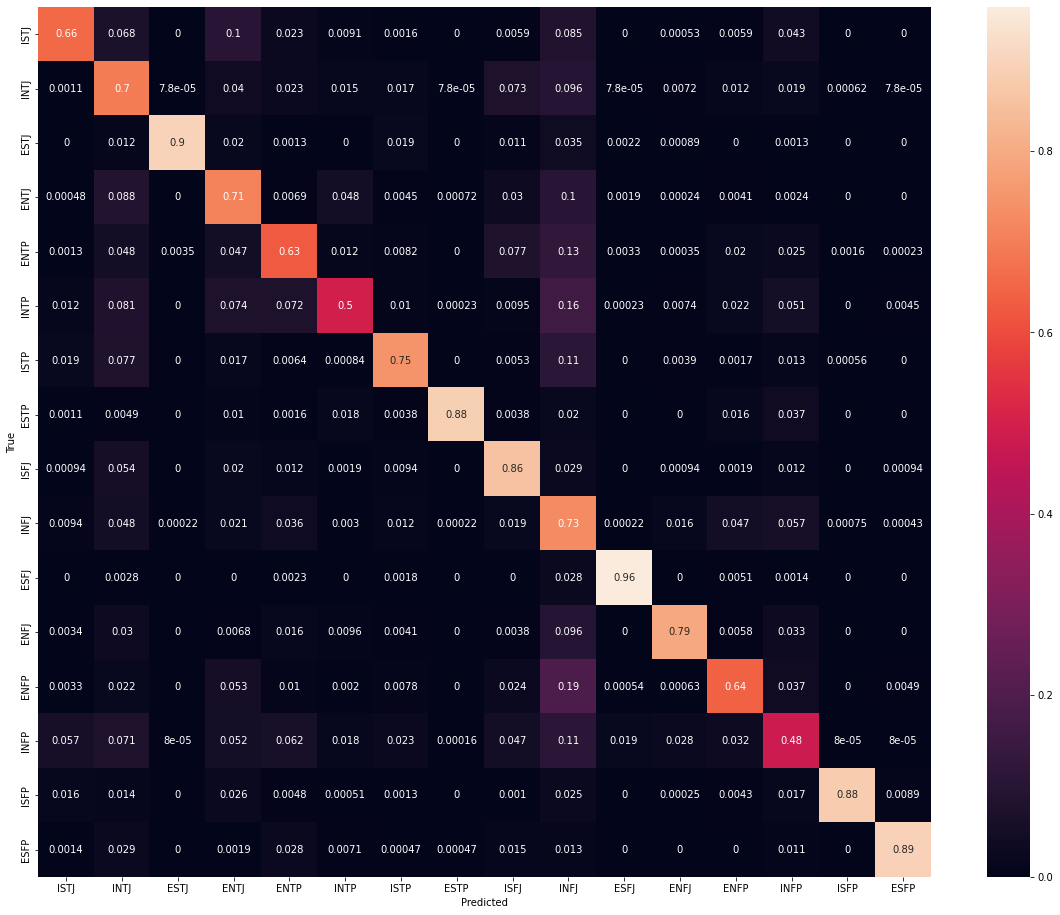

In [34]:
#run the tests
input = test_dataset['message']
hyp_predictions = hyp_w266_setfit_mbti.predict(input)
test_labels = test_dataset['label']
nptest_labels = np.asarray(test_labels)
hyp_multiclass_predictions = hyp_predictions
print(classification_report(nptest_labels, hyp_multiclass_predictions,target_names=valid_MBTI))
cr_multi = classification_report(nptest_labels, hyp_multiclass_predictions, target_names=valid_MBTI)

cm_multi = confusion_matrix(nptest_labels, hyp_multiclass_predictions)
cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(20,16))
sns.heatmap(
      cm_multi, annot=True,
      xticklabels=valid_MBTI,
      yticklabels=valid_MBTI)
plt.xlabel("Predicted")
plt.ylabel("True")

In [203]:
((0.66-0.61)/0.61)*100

8.196721311475418

## weighted accuracy was at 61% which improved to 66% after hyperparameter were applied from the best run, we achieved about 8% gains in the accuracy

# Additional Testing

In [36]:
#additional testing
add_mbti_data = read_parquet_google_cloud('dev_mbti_data.parquet')
add_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')
add_mbti_data = add_mbti_data[['Username','Age','Posts','Occupation','message']]


In [37]:
#get data and labels data together 
add_combined = pd.concat([add_mbti_data,add_mbti_labels],axis=1)
#map the labels to a valid class
add_combined['label']= add_combined['MBTI Type'].map(valid_MBTI)
add_combined


,Username,Age,Posts,Occupation,message,original index,MBTI Type,label
1200000,ajblaise,35.0,7914,web development,thank you for this perspective. it is aston...,22565,INTP,5
1200001,red memories,24.0,6315,record store guru,[mediayoutube]YYYezewYYYkopui[/media],1147480,ESFP,15
1200002,thatswhathesaid,42.0,7256,graphic design,"oh, i would also like to add that they are the...",1445690,INTP,5
1200003,lowtech redneck,44.0,3711,None,revysleetles is trying to register a new accou...,873015,INTP,5
1200004,synarch,45.0,8447,None,"repost and this is basic, well know stuff here...",1380370,ENTP,4
...,...,...,...,...,...,...,...,...
1399995,sillysapienne,40.0,9801,caregiver,"this makes sense. after all, ignorance is b...",1261333,ENFP,12
1399996,chimerical,38.0,898,watching my shadow,"actually, i have heard that men are aroused by...",248780,INTJ,1
1399997,hellena handbasket,40.0,1152,queen of the wild things,"it is a move backwards. eventually, those me...",589746,INFJ,9
1399998,ghost of the dead horse,44.0,3553,None,i am not sure about if my strategy is really u...,539576,ENTJ,3


In [38]:
add_dataset = Dataset.from_pandas(add_combined)

In [39]:
add_dataset

Dataset({
    features: ['Username', 'Age', 'Posts', 'Occupation', 'message', 'original index', 'MBTI Type', 'label'],
    num_rows: 200000
})

In [40]:
#feature engineering
add_dataset = add_dataset.map(lambda example:{'message': example['Username']+' SEP '+
                                                    str(example['Age'])+' SEP '+
                                                    str(example['Posts'])+' SEP '+
                                                    str(example['Occupation'])+' SEP '+
                                                    ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(example['message']).items() if value > 0) + ' SEP ' +
                                                    ', '.join(f'{key} {str(value)}' for key, value in NRCLex(example['message']).raw_emotion_scores.items() if value > 0) + ' SEP ' +
                                                    ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(example['message']))).items()) +' SEP ' +
                                                    example['message']})
# remove additional columns
add_dataset = add_dataset.remove_columns(["Username",'Age','Posts','Occupation','original index','MBTI Type'])


  0%|          | 0/200000 [00:00<?, ?ex/s]

In [42]:
add_dataset

Dataset({
    features: ['message', 'label'],
    num_rows: 200000
})

In [50]:
add_labels[:10]

array([ 5, 15,  5,  5,  4, 10,  1,  5, 14, 15])

In [51]:
add_predictions[:10]

array([ 9, 15,  4,  9,  4, 10,  9,  5, 14, 15])

              precision    recall  f1-score   support

        ISTJ       0.53      0.67      0.59      4117
        INTJ       0.68      0.69      0.68     27543
        ESTJ       0.98      0.91      0.94      4729
        ENTJ       0.44      0.72      0.54      8923
        ENTP       0.66      0.64      0.65     18128
        INTP       0.88      0.50      0.64     27934
        ISTP       0.74      0.76      0.75      7487
        ESTP       0.99      0.87      0.93      3779
        ISFJ       0.24      0.86      0.37      2265
        INFJ       0.42      0.72      0.53     20230
        ESFJ       0.89      0.95      0.92      4723
        ENFJ       0.75      0.80      0.78      6191
        ENFP       0.82      0.64      0.72     23928
        INFP       0.72      0.49      0.58     27086
        ISFP       0.99      0.89      0.94      8547
        ESFP       0.92      0.88      0.90      4390

    accuracy                           0.66    200000
   macro avg       0.73   

Text(159.0, 0.5, 'True')

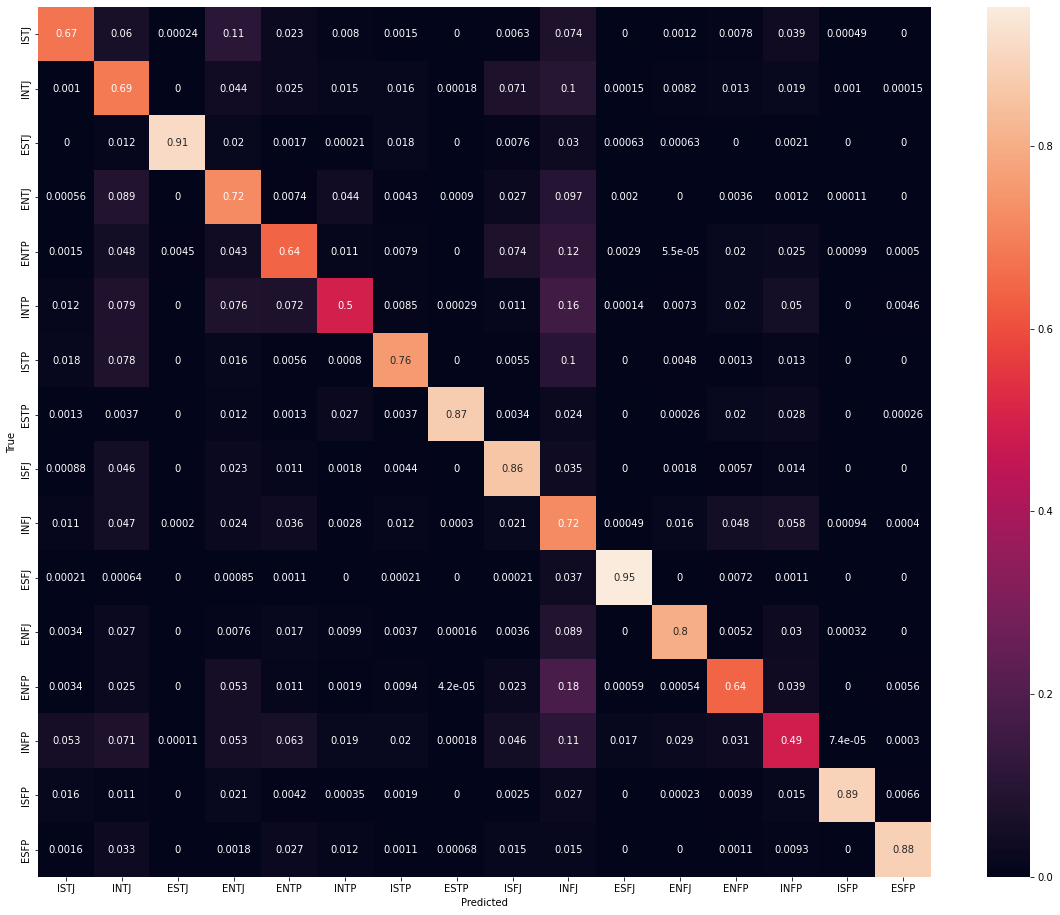

In [46]:
add_input = add_dataset['message'] 
add_labels = add_dataset['label']
add_labels = np.asarray(add_labels)
add_predictions = hyp_w266_setfit_mbti.predict(add_input)


print(classification_report(add_labels, add_predictions,target_names=valid_MBTI))
cr_multi = classification_report(add_labels, add_predictions, target_names=valid_MBTI)

cm_multi = confusion_matrix(add_labels, add_predictions)
cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(20,16))
sns.heatmap(
      cm_multi, annot=True,
      xticklabels=valid_MBTI,
      yticklabels=valid_MBTI)
plt.xlabel("Predicted")
plt.ylabel("True")

# Additional Data Error Analysis

In [62]:
feature = add_dataset['message']

In [64]:
type(feature)

list

In [58]:
# Merge results with data frame
add_combined['prediction'] = add_predictions.tolist()

In [ ]:
# get the feature engineered message from dataset
feature = add_dataset['message']

In [65]:
# add features backinto dataframe
add_combined['feature'] = feature

In [67]:
#now we have orignial message, user profile information, label, feature engineering message and predictions together
add_combined

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature
1200000,ajblaise,35.0,7914,web development,thank you for this perspective. it is aston...,22565,INTP,5,9,ajblaise SEP 35.0 SEP 7914 SEP web development...
1200001,red memories,24.0,6315,record store guru,[mediayoutube]YYYezewYYYkopui[/media],1147480,ESFP,15,15,red memories SEP 24.0 SEP 6315 SEP record stor...
1200002,thatswhathesaid,42.0,7256,graphic design,"oh, i would also like to add that they are the...",1445690,INTP,5,4,thatswhathesaid SEP 42.0 SEP 7256 SEP graphic ...
1200003,lowtech redneck,44.0,3711,None,revysleetles is trying to register a new accou...,873015,INTP,5,9,lowtech redneck SEP 44.0 SEP 3711 SEP None SEP...
1200004,synarch,45.0,8447,None,"repost and this is basic, well know stuff here...",1380370,ENTP,4,4,synarch SEP 45.0 SEP 8447 SEP None SEP money 1...
...,...,...,...,...,...,...,...,...,...,...
1399995,sillysapienne,40.0,9801,caregiver,"this makes sense. after all, ignorance is b...",1261333,ENFP,12,12,sillysapienne SEP 40.0 SEP 9801 SEP caregiver ...
1399996,chimerical,38.0,898,watching my shadow,"actually, i have heard that men are aroused by...",248780,INTJ,1,12,chimerical SEP 38.0 SEP 898 SEP watching my sh...
1399997,hellena handbasket,40.0,1152,queen of the wild things,"it is a move backwards. eventually, those me...",589746,INFJ,9,9,hellena handbasket SEP 40.0 SEP 1152 SEP queen...
1399998,ghost of the dead horse,44.0,3553,None,i am not sure about if my strategy is really u...,539576,ENTJ,3,8,ghost of the dead horse SEP 44.0 SEP 3553 SEP ...


In [68]:
# add accuracy indicator on each observation
add_combined['accurate'] = add_combined['label']== add_combined['prediction']

In [87]:
# add message length and feature lenghts to the dataframe
add_combined['message_len'] = add_combined['message'].str.split().str.len()

In [89]:
add_combined['feature_len'] = add_combined['feature'].str.split().str.len()

In [90]:
add_combined

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature,accurate,message_len,feature_len
1200000,ajblaise,35.0,7914,web development,thank you for this perspective. it is aston...,22565,INTP,5,9,ajblaise SEP 35.0 SEP 7914 SEP web development...,False,10,52
1200001,red memories,24.0,6315,record store guru,[mediayoutube]YYYezewYYYkopui[/media],1147480,ESFP,15,15,red memories SEP 24.0 SEP 6315 SEP record stor...,True,1,19
1200002,thatswhathesaid,42.0,7256,graphic design,"oh, i would also like to add that they are the...",1445690,INTP,5,4,thatswhathesaid SEP 42.0 SEP 7256 SEP graphic ...,False,74,192
1200003,lowtech redneck,44.0,3711,None,revysleetles is trying to register a new accou...,873015,INTP,5,9,lowtech redneck SEP 44.0 SEP 3711 SEP None SEP...,False,28,68
1200004,synarch,45.0,8447,None,"repost and this is basic, well know stuff here...",1380370,ENTP,4,4,synarch SEP 45.0 SEP 8447 SEP None SEP money 1...,True,156,289
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399995,sillysapienne,40.0,9801,caregiver,"this makes sense. after all, ignorance is b...",1261333,ENFP,12,12,sillysapienne SEP 40.0 SEP 9801 SEP caregiver ...,True,9,44
1399996,chimerical,38.0,898,watching my shadow,"actually, i have heard that men are aroused by...",248780,INTJ,1,12,chimerical SEP 38.0 SEP 898 SEP watching my sh...,False,38,101
1399997,hellena handbasket,40.0,1152,queen of the wild things,"it is a move backwards. eventually, those me...",589746,INFJ,9,9,hellena handbasket SEP 40.0 SEP 1152 SEP queen...,True,39,105
1399998,ghost of the dead horse,44.0,3553,None,i am not sure about if my strategy is really u...,539576,ENTJ,3,8,ghost of the dead horse SEP 44.0 SEP 3553 SEP ...,False,595,788


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


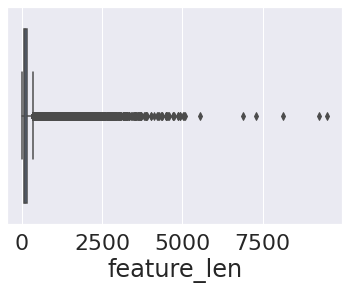

In [204]:
#check for outliars in the message length
sns.boxplot(add_combined['feature_len'])

## mpnet v2 will truncate input text longer than 384 word pieces. we have lot of outliars in our additional testing dataset in terms of feature length, let us focus on feature length in 2 groups i.e <=384 and > 384



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b6fd86c50>,
      dtype=object)

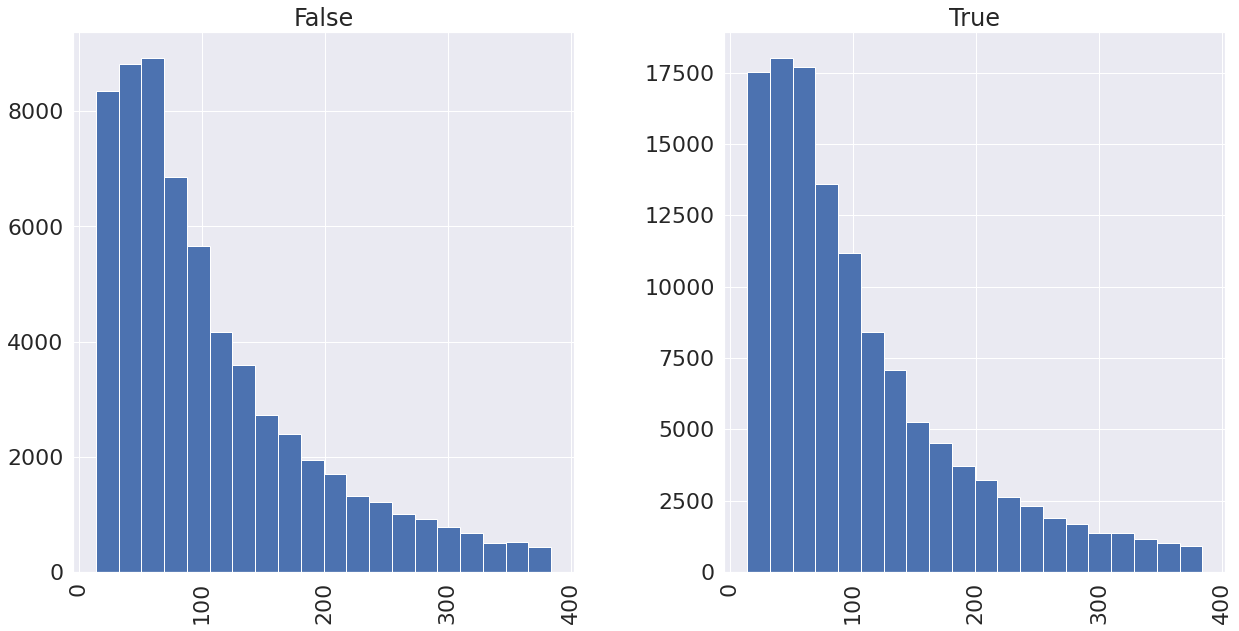

In [205]:
add_combined['feature_len'][add_combined['feature_len'] <= 384].hist(by=add_combined['accurate'],bins=20,figsize=(20,10))

Text(0, 0.5, 'Count')

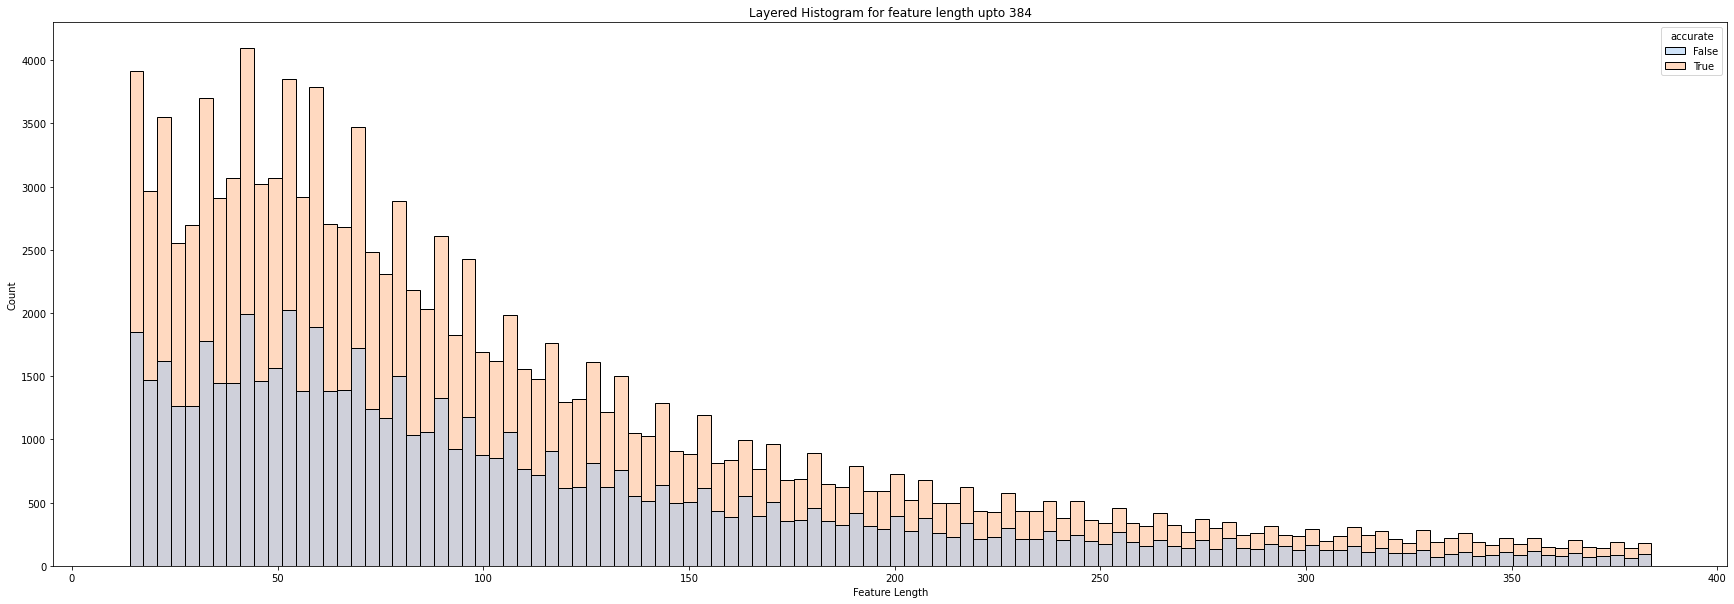

In [168]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=add_combined[add_combined['feature_len'] <= 384], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length upto 384")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

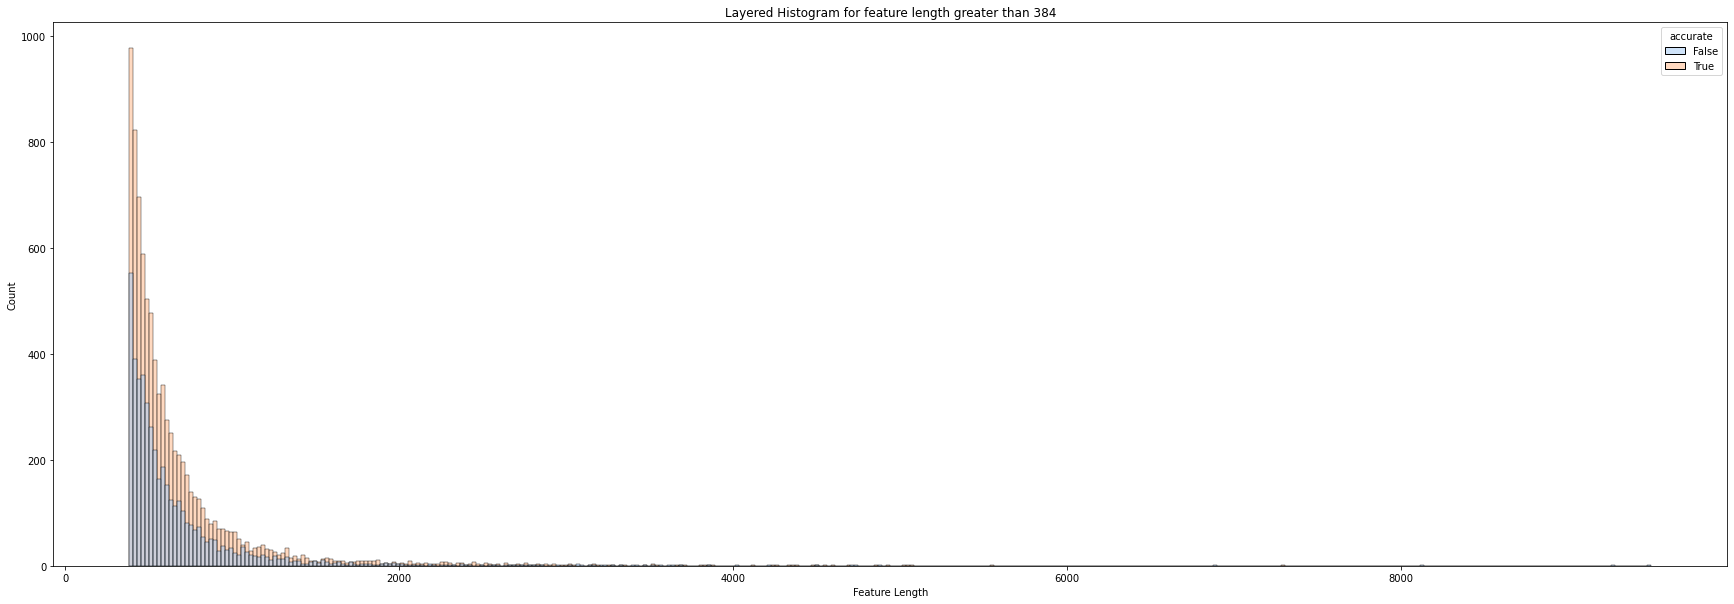

In [172]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=add_combined[add_combined['feature_len'] > 384 ], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length greater than 384")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")

## * Our features do help to cirumvent the limit of 384 words from mpnetv2 as we can see from above that even for lengths > 384 we are mostly able to infer on correct MBTI classification

Text(0, 0.5, 'Count')

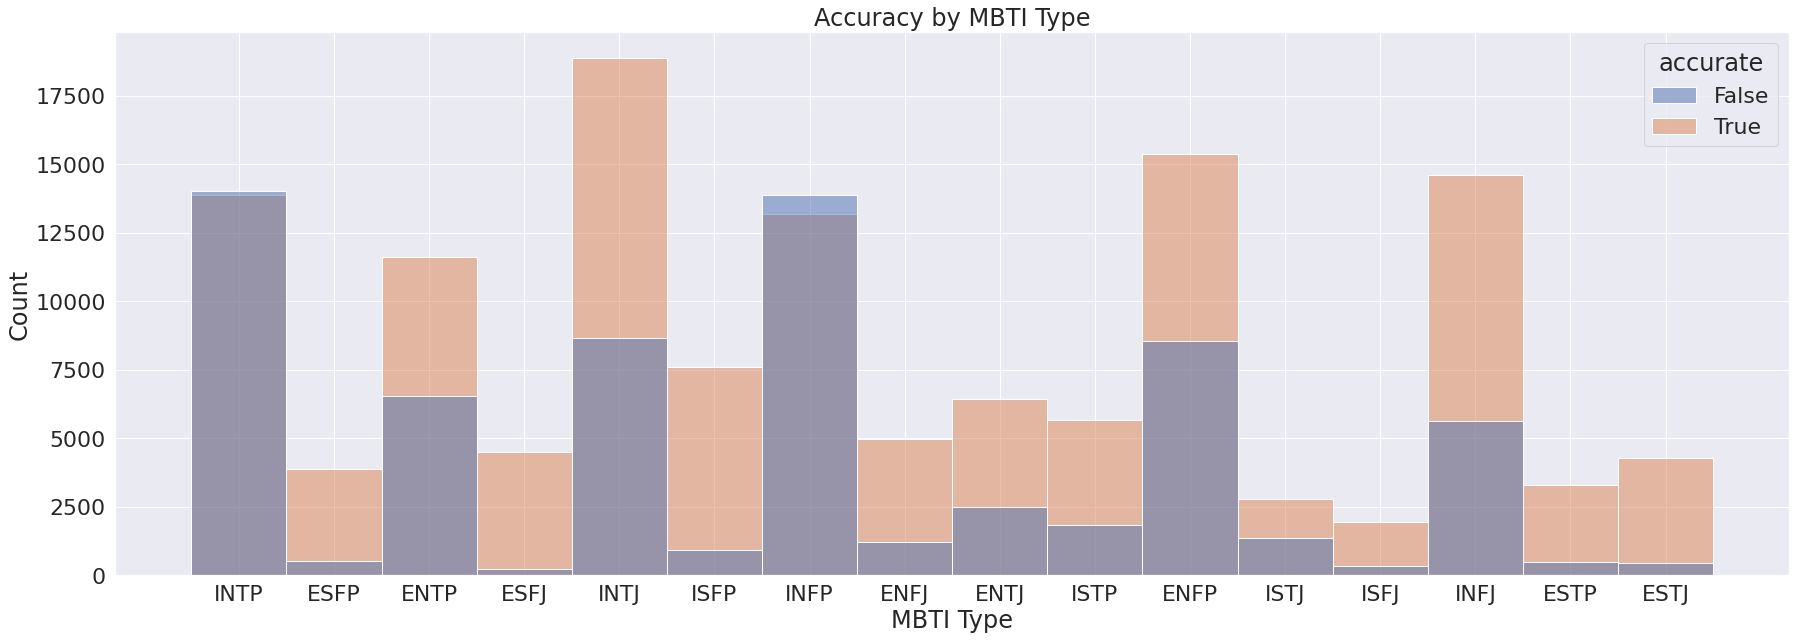

In [206]:
f = plt.figure(figsize=(30,10))
sns.set(font_scale=2)
ax = f.add_subplot(1,1,1)
#sns.histplot(data=add_combined, x="MBTI Type", color="skyblue", label="accurate", kde=True,hue="accurate")
sns.histplot(data=add_combined, x="MBTI Type",  label="accurate", kde=False,hue="accurate")
#sns.histplot(data=add_combined, x="Posts", color="red", label="Posts", kde=True,hue="accurate")
ax.set_title("Accuracy by MBTI Type")
ax.set_xlabel("MBTI Type")
ax.set_ylabel("Count")

## *Most of the errornous predictions are for "IN" combination i.e "IN"-TP, "IN"-TJ, "IN"-FP, "IN"-FJ 
## *Other observable trend is for N vs S in 2nd position for extroverts i.e ENTP + ENFP  has much more errors than ESTP + ESFP
#### Let us drill down into those

In [187]:
in_lst=['INTP', 'INTJ','INFP', 'INFJ']

In [196]:
n_vs_s_lst=['ENTP','ENFP']

Text(0, 0.5, 'Count')

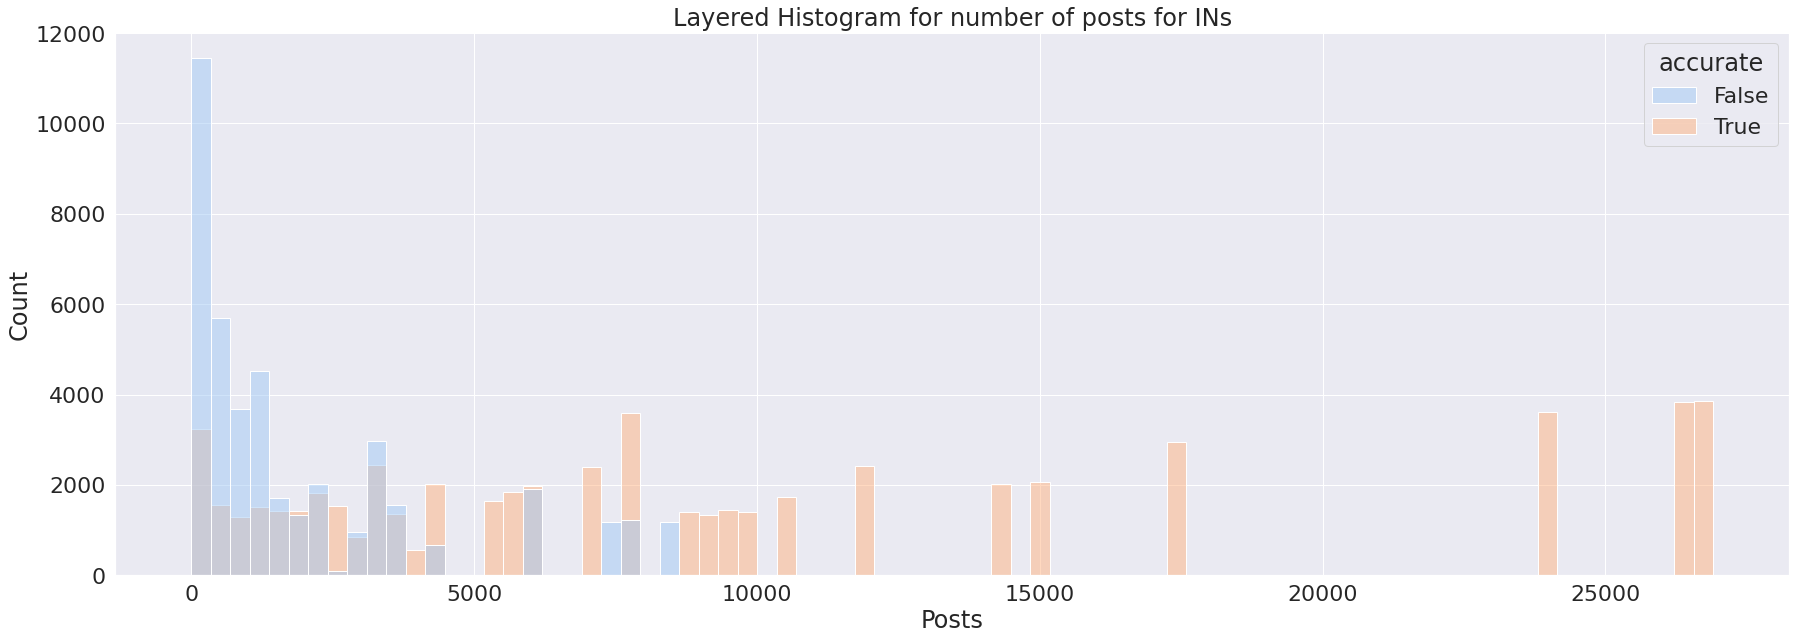

In [209]:
# stacked histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=add_combined[add_combined['MBTI Type'].isin(in_lst)], ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for number of posts for INs")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

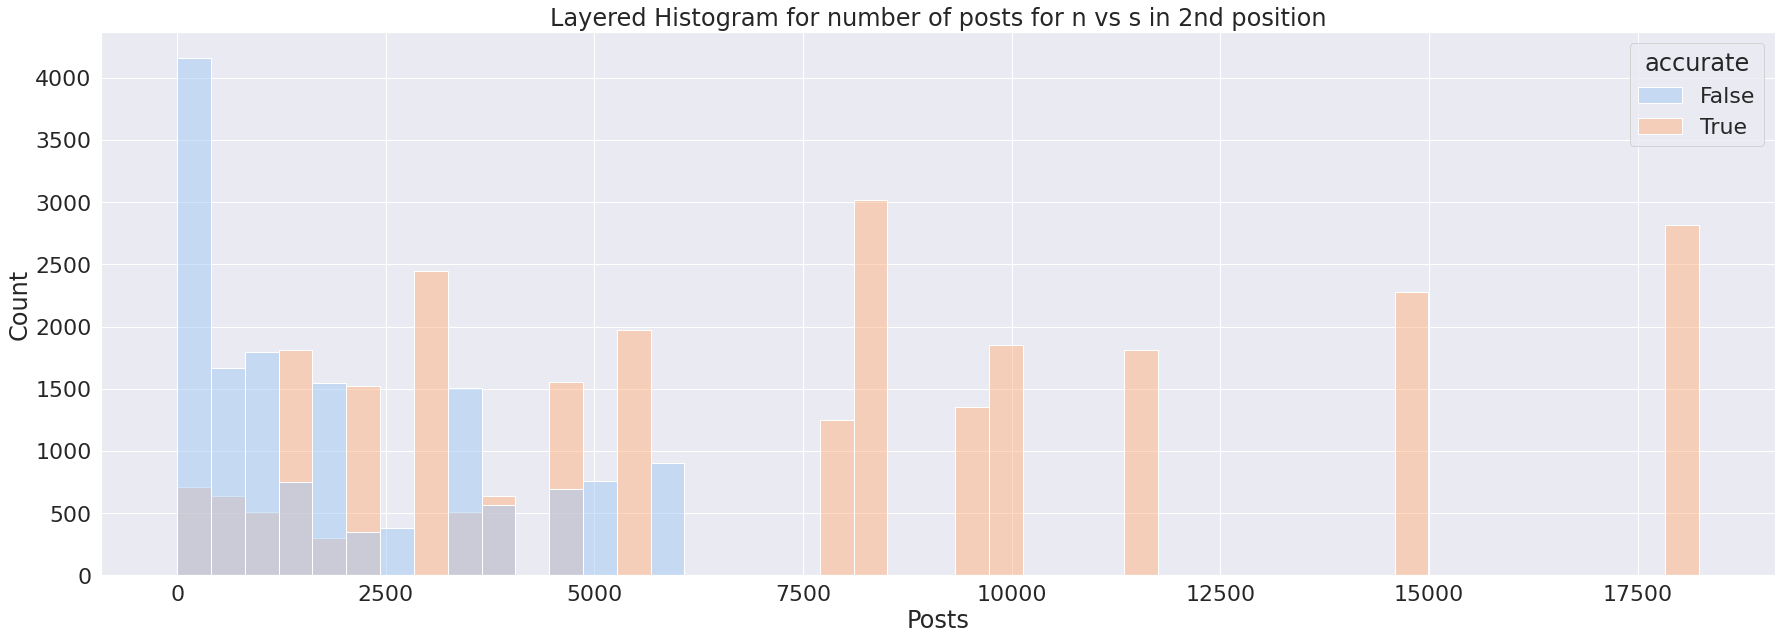

In [210]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=add_combined[add_combined['MBTI Type'].isin(n_vs_s_lst)], ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for number of posts for n vs s in 2nd position")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

## Across both drill downs, as number of posts increase the error in predictions increase

Text(0, 0.5, 'Count')

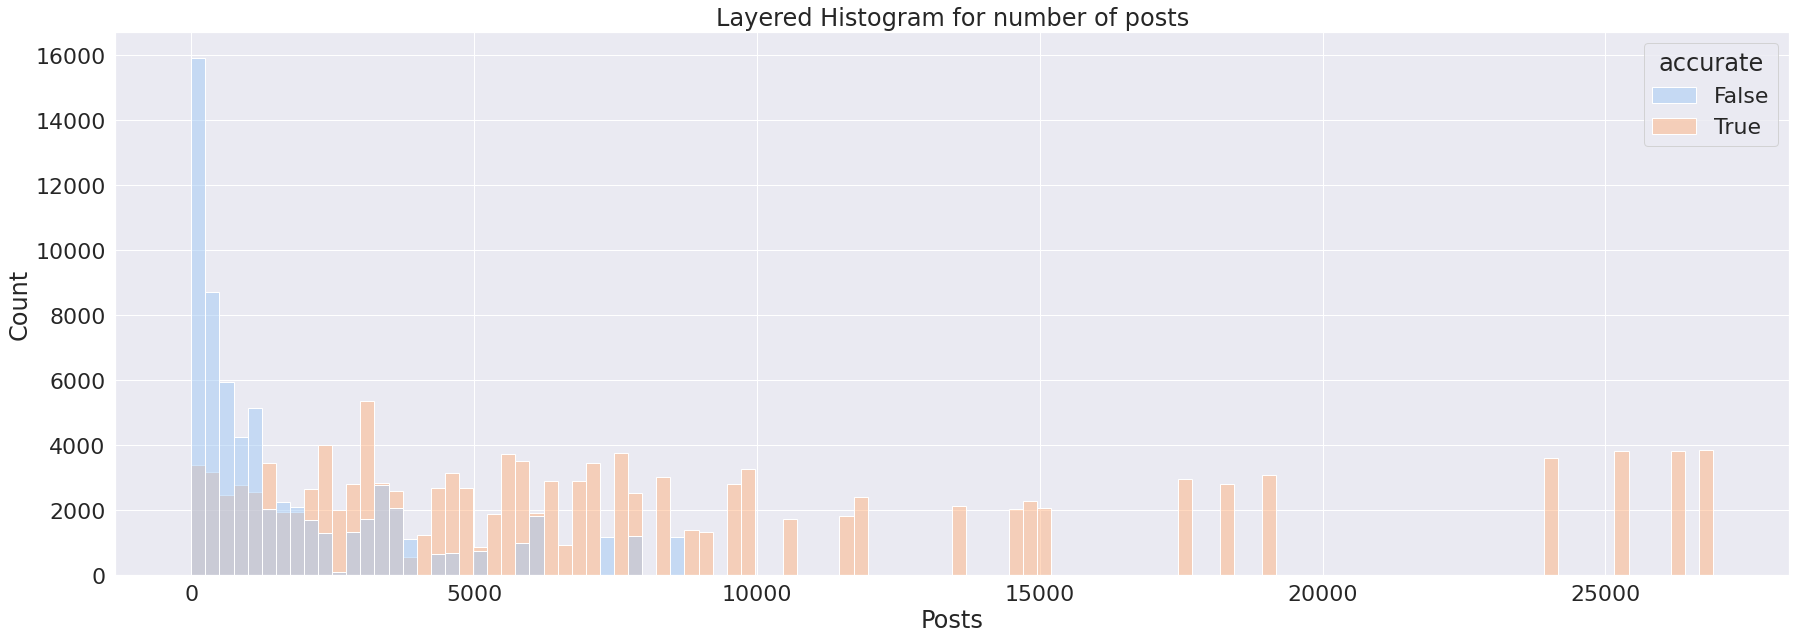

In [211]:
# stacked histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=add_combined, ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for number of posts")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

## From above graph it is evident that our model is struggling to predict correct personality type as number of posts from the users are above 5000

In [212]:
add_combined.groupby(['MBTI Type', 'accurate'])['Posts'].count().unstack().sort_values(by=['MBTI Type'])

accurate,False,True
MBTI Type,,
ENFJ,1220,4971
ENFP,8555,15373
ENTJ,2476,6447
ENTP,6527,11601
ESFJ,227,4496
ESFP,521,3869
ESTJ,436,4293
ESTP,474,3305
INFJ,5621,14609


# Round 2 at SetFit with mpnet v2 for comparision with BERT multiheaded attention model ..no additional features yet. for pure comparison purposes with multiheaded BERT Attetion model

In [216]:
#load training data # delete this cell later
#training 
train_mbti_data = read_parquet_google_cloud('train_uniform_mbti_data.parquet')
train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message']]
#get data and labels data together 
train_combined = pd.concat([train_mbti_data,train_mbti_labels],axis=1)
#map the labels to a valid class
train_combined['label']= train_combined['MBTI Type'].map(valid_MBTI)
t_dataset = Dataset.from_pandas(train_combined)
# Create samples for SetFit Training
seed=20
labels = 16
samples_per_label = 64
sampled_datasets = []
# find the number of samples per label
for i in range(labels):
    sampled_datasets.append(t_dataset.filter(lambda x: x["label"] == i).shuffle(seed=seed).select(range(samples_per_label)))

# concatenate the sampled datasets
from datasets import concatenate_datasets
train_dataset = concatenate_datasets(sampled_datasets)

#Training feature engineering
train_dataset = train_dataset.map(lambda example:{'message': example['Username']+' SEP '+
                                                    str(example['Age'])+' SEP '+
                                                    str(example['Posts'])+' SEP '+
                                                    str(example['Occupation'])+' SEP '+
                                                    ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(example['message']).items() if value > 0) + ' SEP ' +
                                                    ', '.join(f'{key} {str(value)}' for key, value in NRCLex(example['message']).raw_emotion_scores.items() if value > 0) + ' SEP ' +
                                                    ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(example['message']))).items()) +' SEP ' +
                                                    example['message']})

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1024 [00:00<?, ?ex/s]

In [221]:
train_dataset

Dataset({
    features: ['Username', 'Age', 'Posts', 'Occupation', 'message', 'original index', 'MBTI Type', 'label'],
    num_rows: 1024
})

In [222]:
add_dataset

Dataset({
    features: ['message', 'label'],
    num_rows: 200000
})

## Round 2 Hyperparameter Search with feature engineering

### Round2 Set the model

In [223]:

# model specfic hyperparameters
def r2_model_init(params):
    params = params or {}
    max_iter = params.get("max_iter", 10) #10 iterations
    solver = params.get("solver", "liblinear")
    model_id = params.get("model_id", "sentence-transformers/all-mpnet-base-v2")
    model_params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained(model_id, **model_params)

# training hyperparameters
def r2_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 2),
        "batch_size": trial.suggest_categorical("batch_size", [4, 8, 16]),
        "num_iterations": trial.suggest_categorical("num_iterations", [10,20]),
        "seed": trial.suggest_int("seed", 1, 40),
        "max_iter": trial.suggest_int("max_iter", 50, 100),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
        "model_id": trial.suggest_categorical(
            "model_id",
            [
                "sentence-transformers/all-mpnet-base-v2",
            ],
        ),
    }





### Round2 Set the hyper parameter trainer

In [224]:
r2_hyp_trainer = SetFitTrainer(
    train_dataset=train_dataset,
    eval_dataset=add_dataset,
    model_init=r2_model_init,
    column_mapping={"message": "text", "label": "label"},
)

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


### Round2 Run the hyperparameter search

In [226]:
r2_best_run = r2_hyp_trainer.hyperparameter_search(direction="maximize", hp_space=r2_hp_space, n_trials=10)

[I 2022-12-01 07:24:07,988] A new study created in memory with name: no-name-17ac8350-bc1a-4e0f-bf7c-7aa7a3711f70
Trial: {'learning_rate': 5.883702828575086e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20, 'seed': 34, 'max_iter': 76, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 2
  Total optimization steps = 5120
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


[I 2022-12-01 09:07:18,729] Trial 0 finished with value: 0.76091 and parameters: {'learning_rate': 5.883702828575086e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20, 'seed': 34, 'max_iter': 76, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.76091.
Trial: {'learning_rate': 9.539644638331996e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20, 'seed': 16, 'max_iter': 83, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 1
  Total optimization steps = 5120
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-01 09:41:47,312] Trial 1 finished with value: 0.714495 and parameters: {'learning_rate': 9.539644638331996e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20, 'seed': 16, 'max_iter': 83, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.76091.
Trial: {'learning_rate': 2.6682162951142085e-05, 'num_epochs': 1, 'batch_size': 4, 'num_iterations': 10, 'seed': 30, 'max_iter': 79, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 1
  Total optimization steps = 5120
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-01 10:05:25,776] Trial 2 finished with value: 0.736315 and parameters: {'learning_rate': 2.6682162951142085e-05, 'num_epochs': 1, 'batch_size': 4, 'num_iterations': 10, 'seed': 30, 'max_iter': 79, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.76091.
Trial: {'learning_rate': 1.4566863109741386e-06, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10, 'seed': 25, 'max_iter': 91, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 2
  Total optimization steps = 2560
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-01 11:02:01,746] Trial 3 finished with value: 0.588505 and parameters: {'learning_rate': 1.4566863109741386e-06, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10, 'seed': 25, 'max_iter': 91, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.76091.
Trial: {'learning_rate': 3.6926982189458805e-05, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 10, 'seed': 7, 'max_iter': 80, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub,

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-01 11:23:48,817] Trial 4 finished with value: 0.73094 and parameters: {'learning_rate': 3.6926982189458805e-05, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 10, 'seed': 7, 'max_iter': 80, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.76091.
Trial: {'learning_rate': 7.284155238485532e-05, 'num_epochs': 2, 'batch_size': 4, 'num_iterations': 10, 'seed': 20, 'max_iter': 88, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 2
  Total optimization steps = 10240
  Total train batch size = 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10240 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10240 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-01 12:27:57,033] Trial 5 finished with value: 0.020585 and parameters: {'learning_rate': 7.284155238485532e-05, 'num_epochs': 2, 'batch_size': 4, 'num_iterations': 10, 'seed': 20, 'max_iter': 88, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.76091.
Trial: {'learning_rate': 4.2848872506915845e-05, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 20, 'seed': 18, 'max_iter': 58, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 1
  Total optimization steps = 2560
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-01 13:01:21,577] Trial 6 finished with value: 0.768875 and parameters: {'learning_rate': 4.2848872506915845e-05, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 20, 'seed': 18, 'max_iter': 58, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 6 with value: 0.768875.
Trial: {'learning_rate': 5.533000518626286e-06, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 20, 'seed': 39, 'max_iter': 58, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 2
  Total optimization steps = 10240
  Total train batch size = 8


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10240 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10240 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-01 14:48:43,226] Trial 7 finished with value: 0.7622 and parameters: {'learning_rate': 5.533000518626286e-06, 'num_epochs': 2, 'batch_size': 8, 'num_iterations': 20, 'seed': 39, 'max_iter': 58, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 6 with value: 0.768875.
Trial: {'learning_rate': 7.110520323517772e-06, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10, 'seed': 17, 'max_iter': 50, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 2
  Total optimization steps = 2560
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-01 15:45:19,792] Trial 8 finished with value: 0.729195 and parameters: {'learning_rate': 7.110520323517772e-06, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10, 'seed': 17, 'max_iter': 50, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 6 with value: 0.768875.
Trial: {'learning_rate': 1.4547017107553963e-05, 'num_epochs': 2, 'batch_size': 4, 'num_iterations': 20, 'seed': 25, 'max_iter': 81, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 2
  Total optimization steps = 20480
  Total train batch size = 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20480 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20480 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-01 17:43:25,041] Trial 9 finished with value: 0.76254 and parameters: {'learning_rate': 1.4547017107553963e-05, 'num_epochs': 2, 'batch_size': 4, 'num_iterations': 20, 'seed': 25, 'max_iter': 81, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 6 with value: 0.768875.


### Round2 Document the best run

In [227]:
#Display the final result of the best hyperparameters that gave highest accuracy
r2_best_run

BestRun(run_id='6', objective=0.768875, hyperparameters={'learning_rate': 4.2848872506915845e-05, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 20, 'seed': 18, 'max_iter': 58, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}, backend=<optuna.study.study.Study object at 0x7f5b719bd110>)

### Round2 Apply the parameters and train and evalute the model

In [228]:
r2_hyp_trainer.apply_hyperparameters(r2_best_run.hyperparameters, final_model=True)
r2_hyp_trainer.train()

r2_hyp_metrics = r2_hyp_trainer.evaluate()

print(f"model used: {r2_best_run.hyperparameters['model_id']}")
print(f"train dataset: {len(train_dataset)} samples")
print(f"accuracy: {r2_hyp_metrics['accuracy']}")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 1
  Total optimization steps = 2560
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


model used: sentence-transformers/all-mpnet-base-v2
train dataset: 1024 samples
accuracy: 0.766245


###Round2 Push the model to huggingface

In [229]:
r2_hyp_trainer.push_to_hub(f"r2-w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'push_to_hub': pass repo_path_or_name='r2-w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30', repo_url=None, commit_message='Add SetFit model', organization=None, private=None, api_endpoint=None, token=None, git_user=None, git_email=None, config=None, skip_lfs_files=False as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'push_to_hub': repo_path_or_name. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Cloning https://huggingface.co/shrinivasbjoshi/r2-w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30 into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.30k/418M [00:00<?, ?B/s]

Upload file model_head.pkl:   3%|3         | 3.30k/97.2k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/shrinivasbjoshi/r2-w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30
   64c37d8..66eac30  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/shrinivasbjoshi/r2-w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30
   64c37d8..66eac30  main -> main



'https://huggingface.co/shrinivasbjoshi/r2-w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30/commit/66eac30721a56e6f3d8575533422d7b9bcb21766'

###Round2 Import the model from hugging face
(Hyperparameter search ran overnight, model was pushed to hugging face )

In [29]:
#model import 
# importing the model from hugging face
r2_hyp_w266_setfit_mbti = SetFitModel.from_pretrained("shrinivasbjoshi/r2-w266-setfit-mbti-multiclass-hypsearch-mpnet-nov30")

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.27k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

###Round2 Plot confusion matirx

In [ ]:
#import the test data now that r2 has not seen for additional testing


In [25]:
test_dataset

Dataset({
    features: ['message', 'label'],
    num_rows: 93106
})

              precision    recall  f1-score   support

        ISTJ       0.90      0.77      0.83      1877
        INTJ       0.72      0.79      0.76     12850
        ESTJ       0.97      0.93      0.95      2243
        ENTJ       0.85      0.90      0.88      4186
        ENTP       0.71      0.70      0.70      8567
        INTP       0.83      0.70      0.76     12925
        ISTP       0.74      0.86      0.79      3576
        ESTP       0.92      0.90      0.91      1840
        ISFJ       0.59      0.88      0.71      1061
        INFJ       0.55      0.75      0.63      9275
        ESFJ       0.88      0.98      0.93      2169
        ENFJ       0.81      0.86      0.84      2920
        ENFP       0.87      0.76      0.81     11048
        INFP       0.77      0.61      0.68     12497
        ISFP       1.00      0.88      0.94      3946
        ESFP       0.79      0.96      0.87      2126

    accuracy                           0.77     93106
   macro avg       0.81   

Text(159.0, 0.5, 'True')

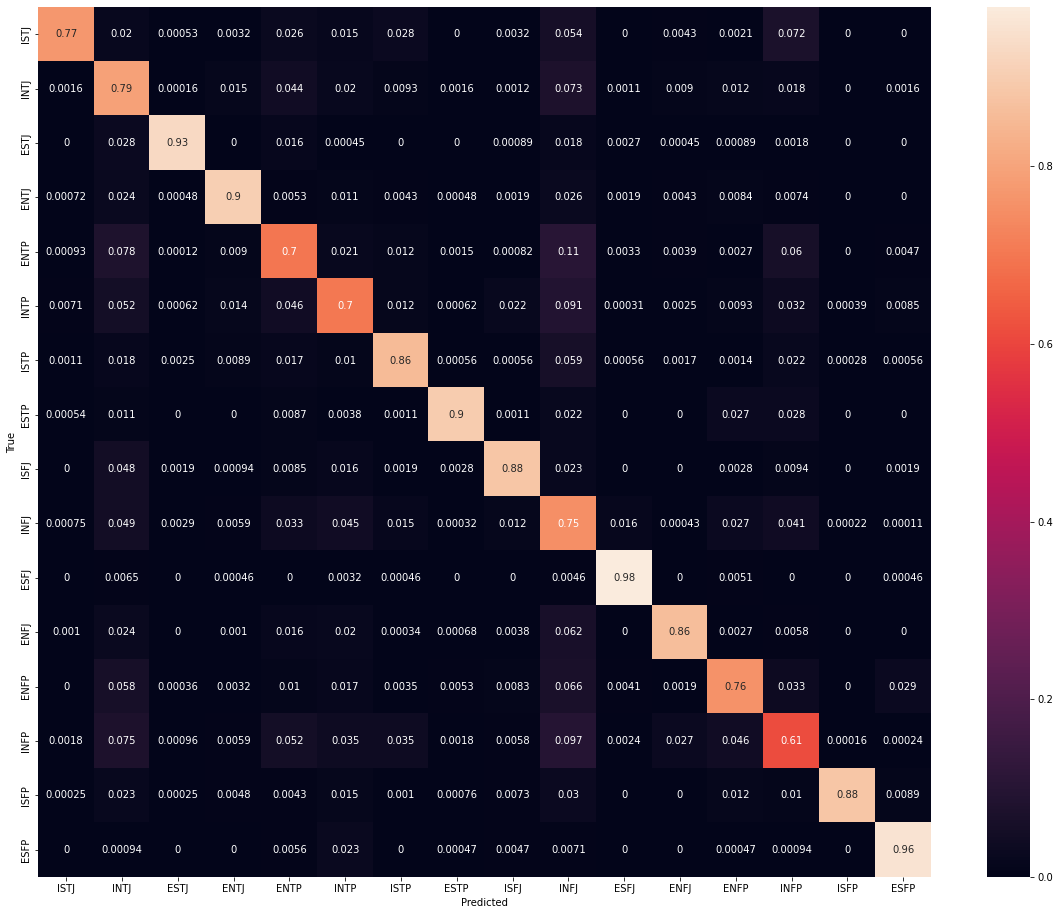

In [30]:
# #run the tests
r2_input = test_dataset['message']
r2_hyp_predictions = r2_hyp_w266_setfit_mbti.predict(r2_input)
test_labels = test_dataset['label']
nptest_labels = np.asarray(test_labels)

print(classification_report(nptest_labels, r2_hyp_predictions,target_names=valid_MBTI))
cr_multi = classification_report(nptest_labels, r2_hyp_predictions, target_names=valid_MBTI)

cm_multi = confusion_matrix(nptest_labels, r2_hyp_predictions)
cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(20,16))
sns.heatmap(
      cm_multi, annot=True,
      xticklabels=valid_MBTI,
      yticklabels=valid_MBTI)
plt.xlabel("Predicted")
plt.ylabel("True")

In [32]:
test_dataset

Dataset({
    features: ['message', 'label'],
    num_rows: 93106
})

# Round2 Additional Data Error Analysis

In [34]:
type(feature)

list

In [35]:
# Merge results with data frame
test_combined['prediction'] = r2_hyp_predictions.tolist()

In [36]:
# get the feature engineered message from dataset
feature = test_dataset['message']

In [37]:
# add features backinto dataframe
test_combined['feature'] = feature

In [38]:
#now we have orignial message, user profile information, label, feature engineering message and predictions together
test_combined

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature
1400000,laurie,49.0,6072,nada,i liked it.,852132,ENFP,12,12,laurie SEP 49.0 SEP 6072 SEP nada SEP SEP SE...
1400001,searchingforpeace,52.0,5569,None,nope just why?,1242759,ENFJ,11,11,searchingforpeace SEP 52.0 SEP 5569 SEP None S...
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",61435,INTP,5,4,anonymous SEP 33.0 SEP 605 SEP None SEP prison...
1400003,eric b,56.0,3620,subway motorman,^ i think so too!! tyrion and brienne are both...,437446,INTP,5,5,eric b SEP 56.0 SEP 3620 SEP subway motorman S...
1400004,yama,28.0,7684,microbiology technician,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,1589900,ESFJ,10,10,yama SEP 28.0 SEP 7684 SEP microbiology techni...
...,...,...,...,...,...,...,...,...,...,...
1493101,coriolis,45.0,26905,None,"a lot of things because me feel guilty, even t...",283920,INTJ,1,1,coriolis SEP 45.0 SEP 26905 SEP None SEP money...
1493102,uumlau,56.0,5517,None,you are so cute. yes you can blow an extraor...,1525910,INTJ,1,1,uumlau SEP 56.0 SEP 5517 SEP None SEP money 1....
1493103,betty blue,45.0,5064,self employed,"vacuumed the whole house, ran greatest distanc...",144864,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...
1493104,jeffster,46.0,6743,office manager for subway (eat fresh!),XXXXc ^?,715585,ESFP,15,15,jeffster SEP 46.0 SEP 6743 SEP office manager ...


In [39]:
# add accuracy indicator on each observation
test_combined['accurate'] = test_combined['label']== test_combined['prediction']

In [40]:
# add message length and feature lenghts to the dataframe
test_combined['message_len'] = test_combined['message'].str.split().str.len()

In [41]:
test_combined['feature_len'] = test_combined['feature'].str.split().str.len()

In [42]:
test_combined

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature,accurate,message_len,feature_len
1400000,laurie,49.0,6072,nada,i liked it.,852132,ENFP,12,12,laurie SEP 49.0 SEP 6072 SEP nada SEP SEP SE...,True,3,20
1400001,searchingforpeace,52.0,5569,None,nope just why?,1242759,ENFJ,11,11,searchingforpeace SEP 52.0 SEP 5569 SEP None S...,True,3,24
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",61435,INTP,5,4,anonymous SEP 33.0 SEP 605 SEP None SEP prison...,False,28,89
1400003,eric b,56.0,3620,subway motorman,^ i think so too!! tyrion and brienne are both...,437446,INTP,5,5,eric b SEP 56.0 SEP 3620 SEP subway motorman S...,True,89,210
1400004,yama,28.0,7684,microbiology technician,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,1589900,ESFJ,10,10,yama SEP 28.0 SEP 7684 SEP microbiology techni...,True,4,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493101,coriolis,45.0,26905,None,"a lot of things because me feel guilty, even t...",283920,INTJ,1,1,coriolis SEP 45.0 SEP 26905 SEP None SEP money...,True,267,414
1493102,uumlau,56.0,5517,None,you are so cute. yes you can blow an extraor...,1525910,INTJ,1,1,uumlau SEP 56.0 SEP 5517 SEP None SEP money 1....,True,161,292
1493103,betty blue,45.0,5064,self employed,"vacuumed the whole house, ran greatest distanc...",144864,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,12,49
1493104,jeffster,46.0,6743,office manager for subway (eat fresh!),XXXXc ^?,715585,ESFP,15,15,jeffster SEP 46.0 SEP 6743 SEP office manager ...,True,2,24


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


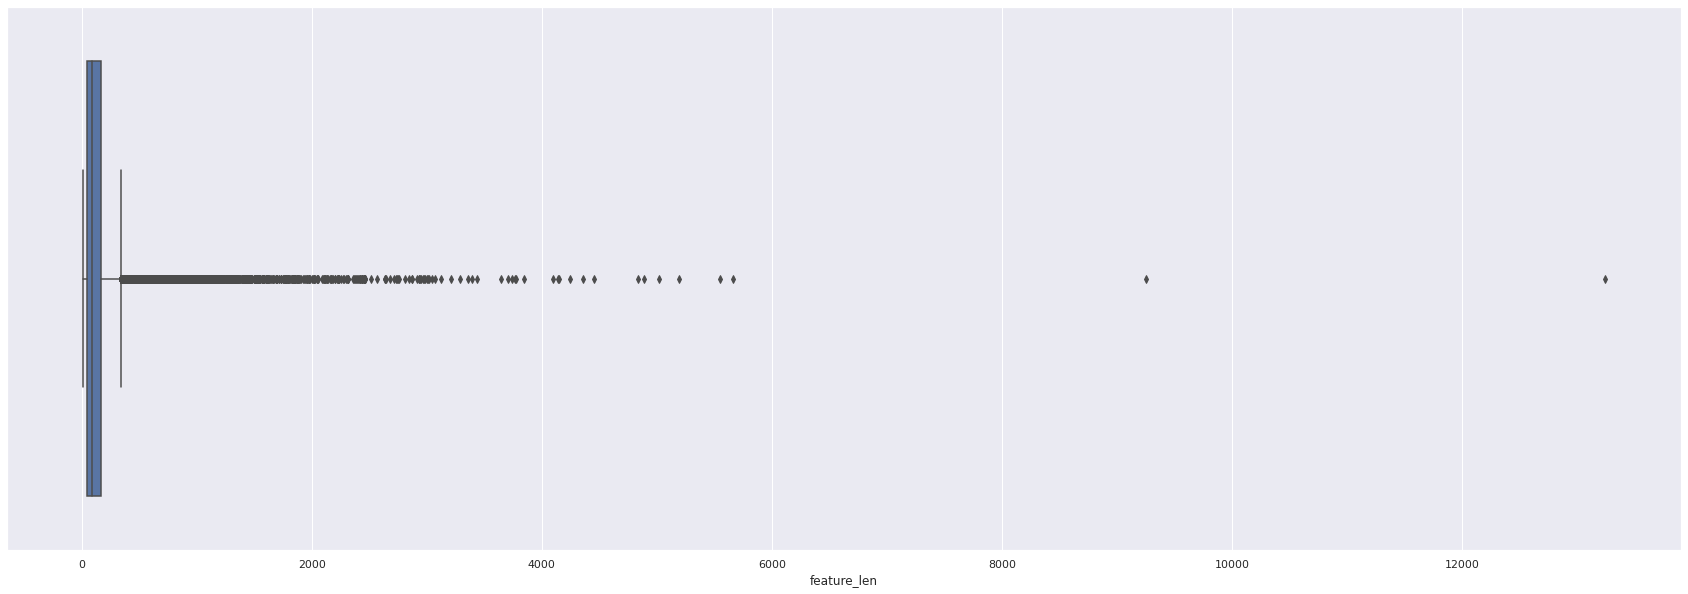

In [90]:
#check for outliars in the message length
sns.set(rc={'figure.figsize':(30,10)})
sns.boxplot(test_combined['feature_len'])

## mpnet v2 will truncate input text longer than 384 word pieces. we have lot of outliars in our additional testing dataset in terms of feature length, let us focus on feature length in 2 groups i.e <=384 and > 384



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb3d30cb90>,
      dtype=object)

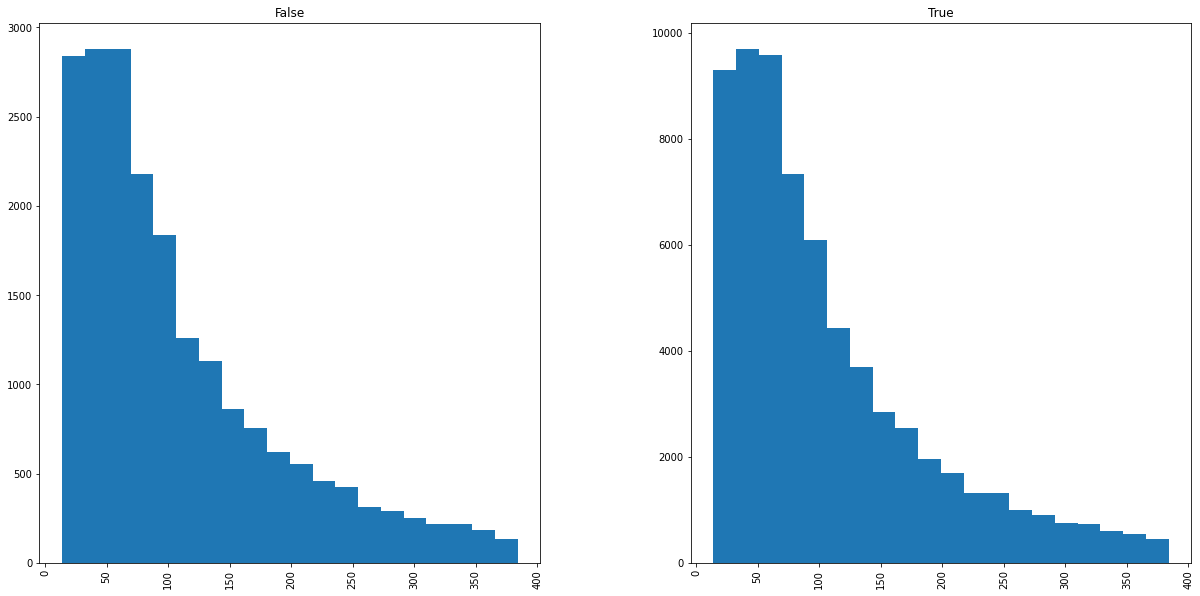

In [45]:
test_combined['feature_len'][test_combined['feature_len'] <= 384].hist(by=test_combined['accurate'],bins=20,figsize=(20,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fca61873fd0>,
      dtype=object)

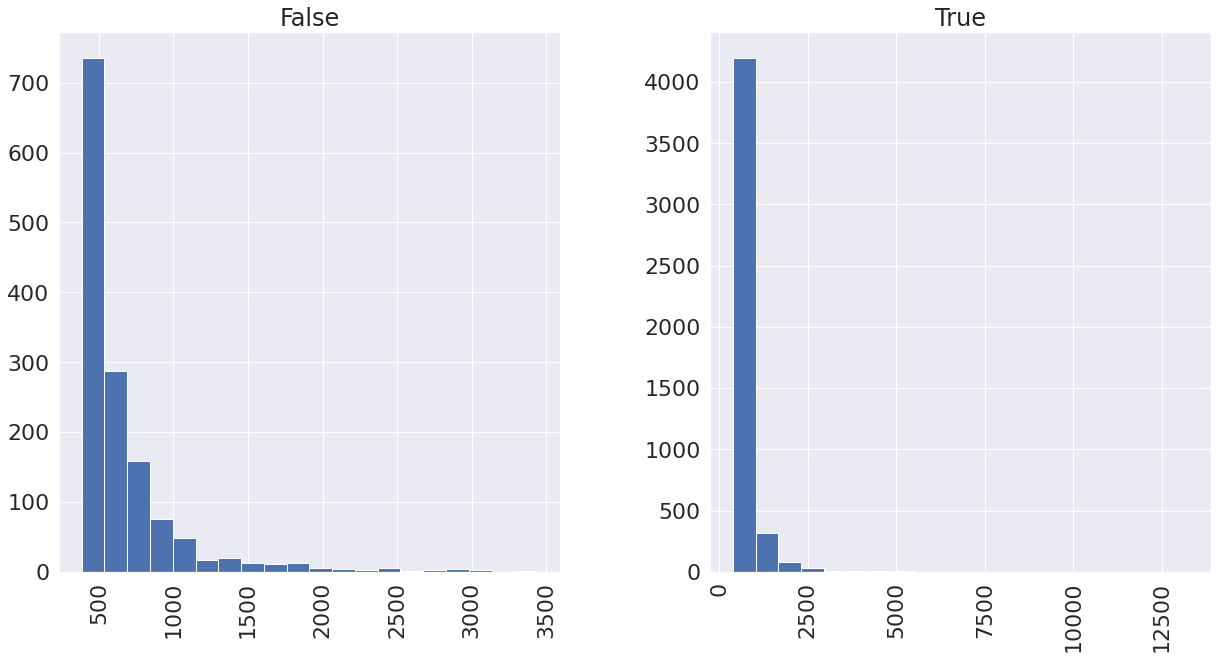

In [182]:
test_combined['feature_len'][test_combined['feature_len'] > 384].hist(by=test_combined['accurate'],bins=20,figsize=(20,10))

In [190]:
test_combined['accurate'][test_combined['feature_len'] > 384].value_counts(normalize = True)

True     0.767887
False    0.232113
Name: accurate, dtype: float64

In [191]:
test_combined['accurate'][test_combined['feature_len'] <= 384].value_counts(normalize = True)

True     0.766866
False    0.233134
Name: accurate, dtype: float64

## It does not seem like that text beyond 384 is hurting the models ability to predict. Our approach to feautre engineering for word embeddings is helping us extract signals and dimensions from the actual message in abstract way and enable us to predict

Text(0, 0.5, 'Count')

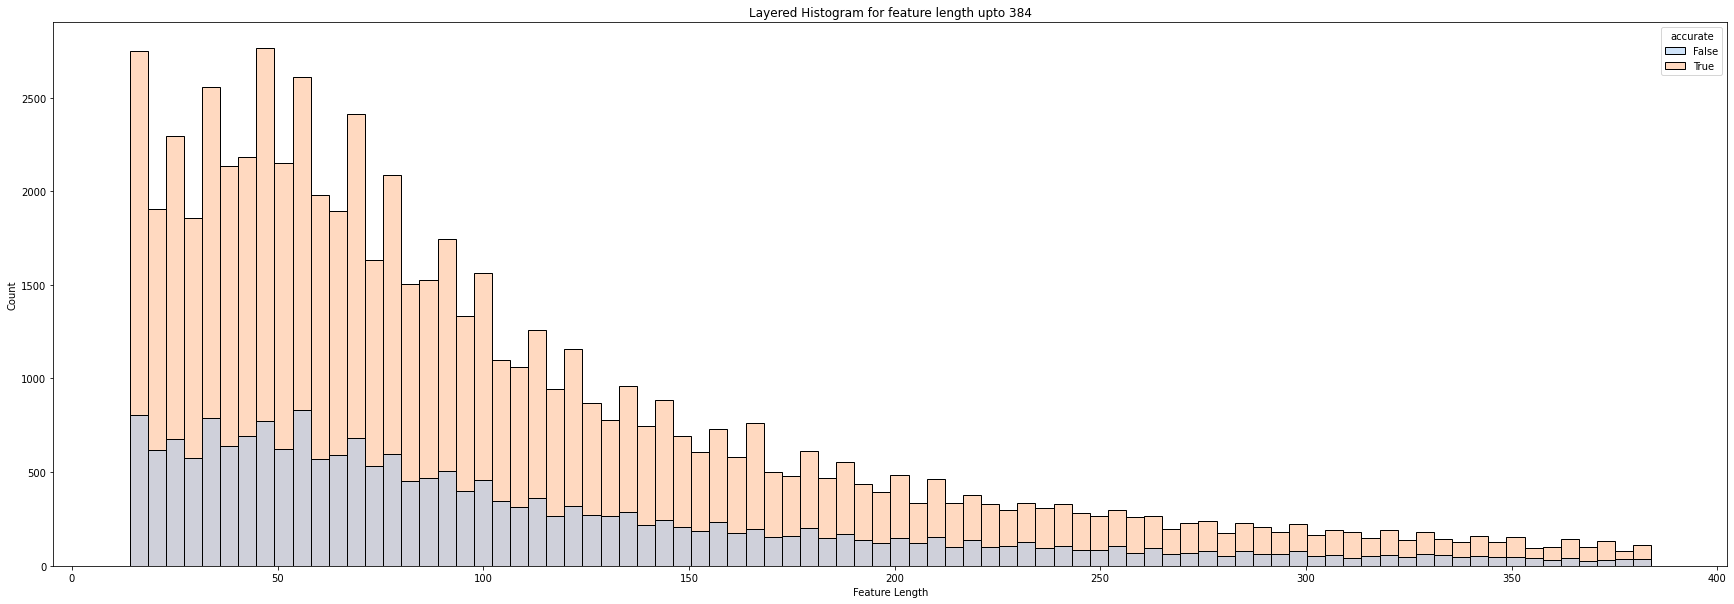

In [46]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_combined[test_combined['feature_len'] <= 384], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length upto 384")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

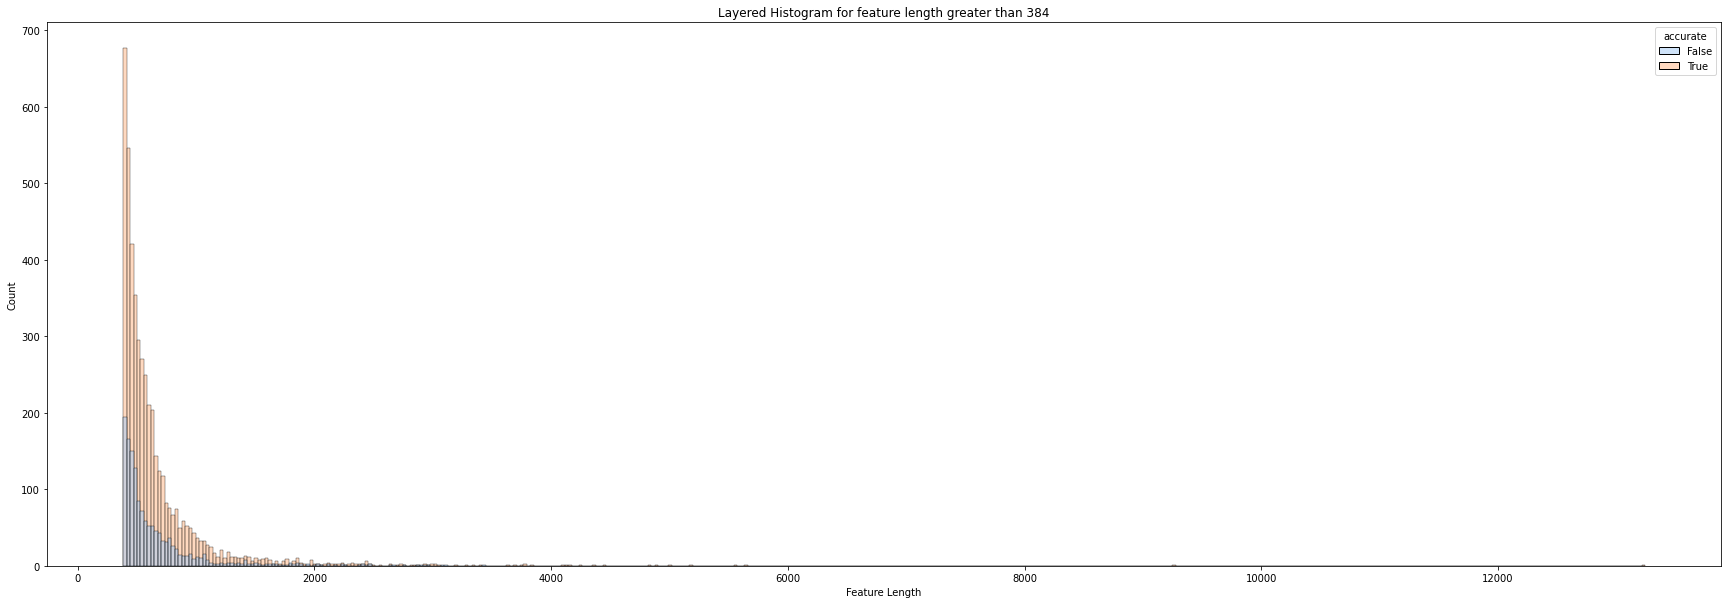

In [47]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_combined[test_combined['feature_len'] > 384 ], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length greater than 384")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")

## * Our features do help to cirumvent the limit of 384 words from mpnetv2 as we can see from above that even for lengths > 384 we are mostly able to infer on correct MBTI classification

In [66]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center",fontsize=10) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left",fontsize=10)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

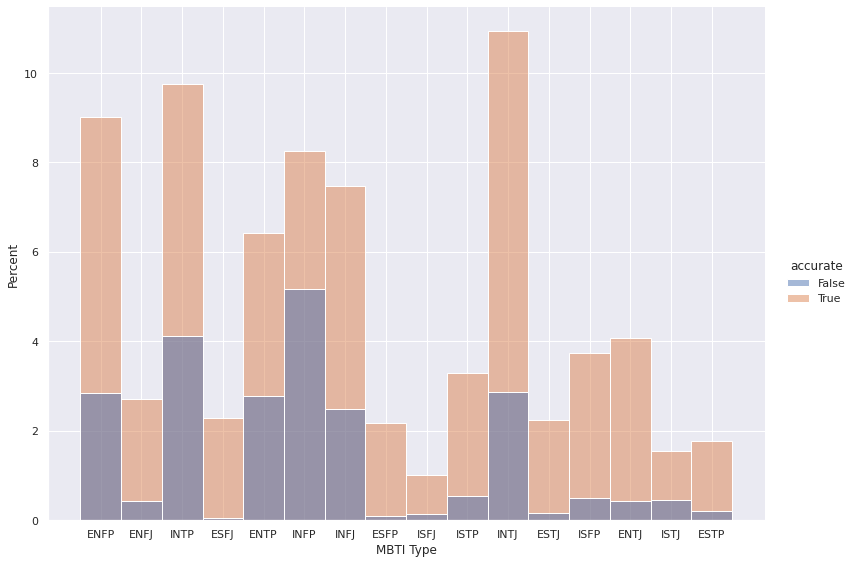

In [119]:
#let us look at percent distribution of errors per MBTI Type
sns.displot(data=test_combined, x='MBTI Type', stat='percent', hue='accurate',height=8, aspect=11/8)

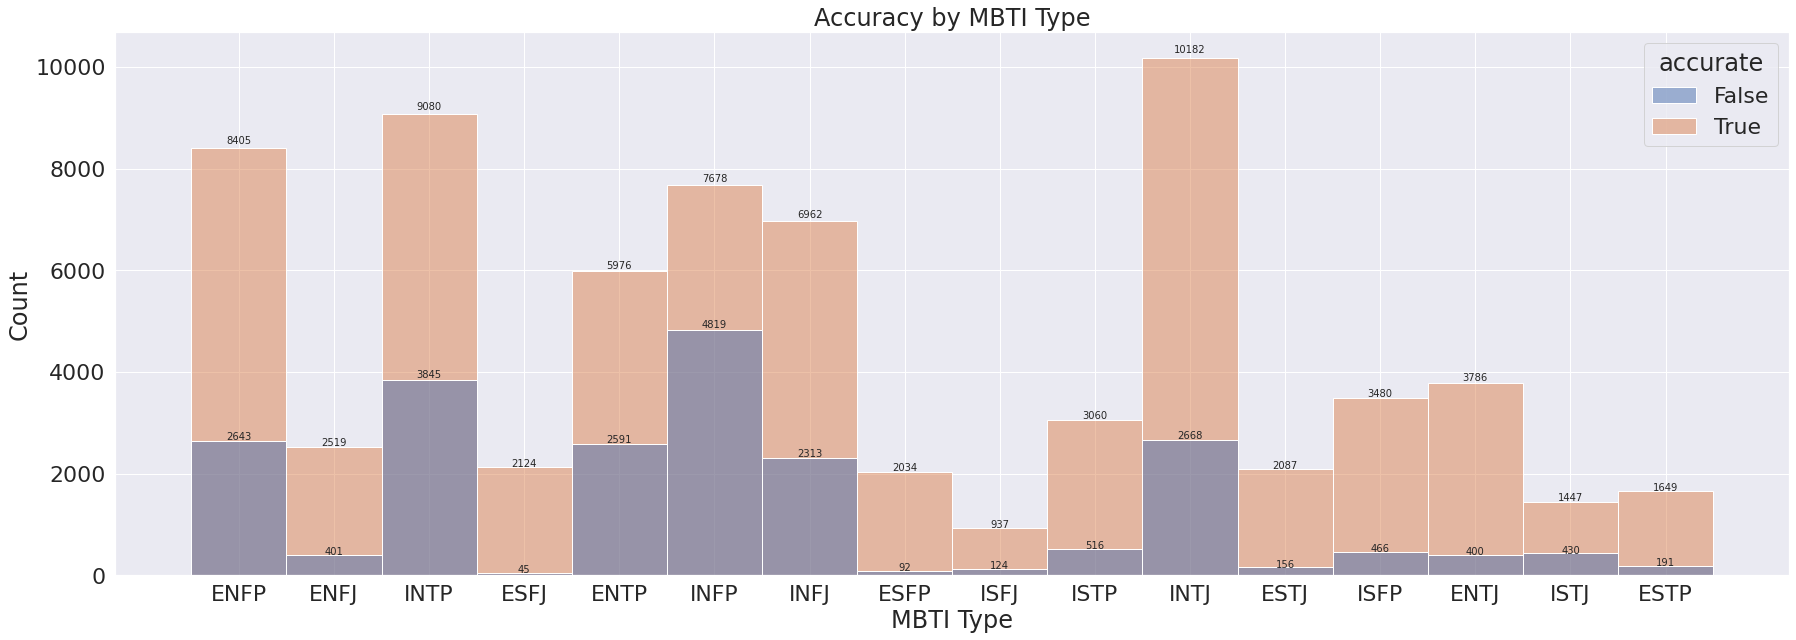

In [120]:
#plot with absolute count
f = plt.figure(figsize=(30,10))
sns.set(font_scale=2)
ax = f.add_subplot(1,1,1)
#sns.histplot(data=add_combined, x="MBTI Type", color="skyblue", label="accurate", kde=True,hue="accurate")
sns.histplot(data=test_combined, x="MBTI Type",  label="accurate", kde=False,hue="accurate")
#sns.histplot(data=add_combined, x="Posts", color="red", label="Posts", kde=True,hue="accurate")
ax.set_title("Accuracy by MBTI Type")
ax.set_xlabel("MBTI Type")
ax.set_ylabel("Count")
show_values(ax)

In [154]:
test_combined.groupby(['MBTI Type'])['accurate'].value_counts(normalize=True).unstack(level=1)

accurate,False,True
MBTI Type,,
ENFJ,0.137329,0.862671
ENFP,0.239229,0.760771
ENTJ,0.095557,0.904443
ENTP,0.302440,0.697560
ESFJ,0.020747,0.979253
ESFP,0.043274,0.956726
ESTJ,0.069550,0.930450
ESTP,0.103804,0.896196
INFJ,0.249380,0.750620


Top 5  errors are in INFP,ENTP,INTP,INFJ,,ENFP

## *Most of the errornous predictions are for INFP,ENTP,INTP,INFJ,ENFP
#### Let us drill down into those

In [157]:
top_5=['INFP','ENTP','INTP','INFJ','ENFP']

Text(0, 0.5, 'Count')

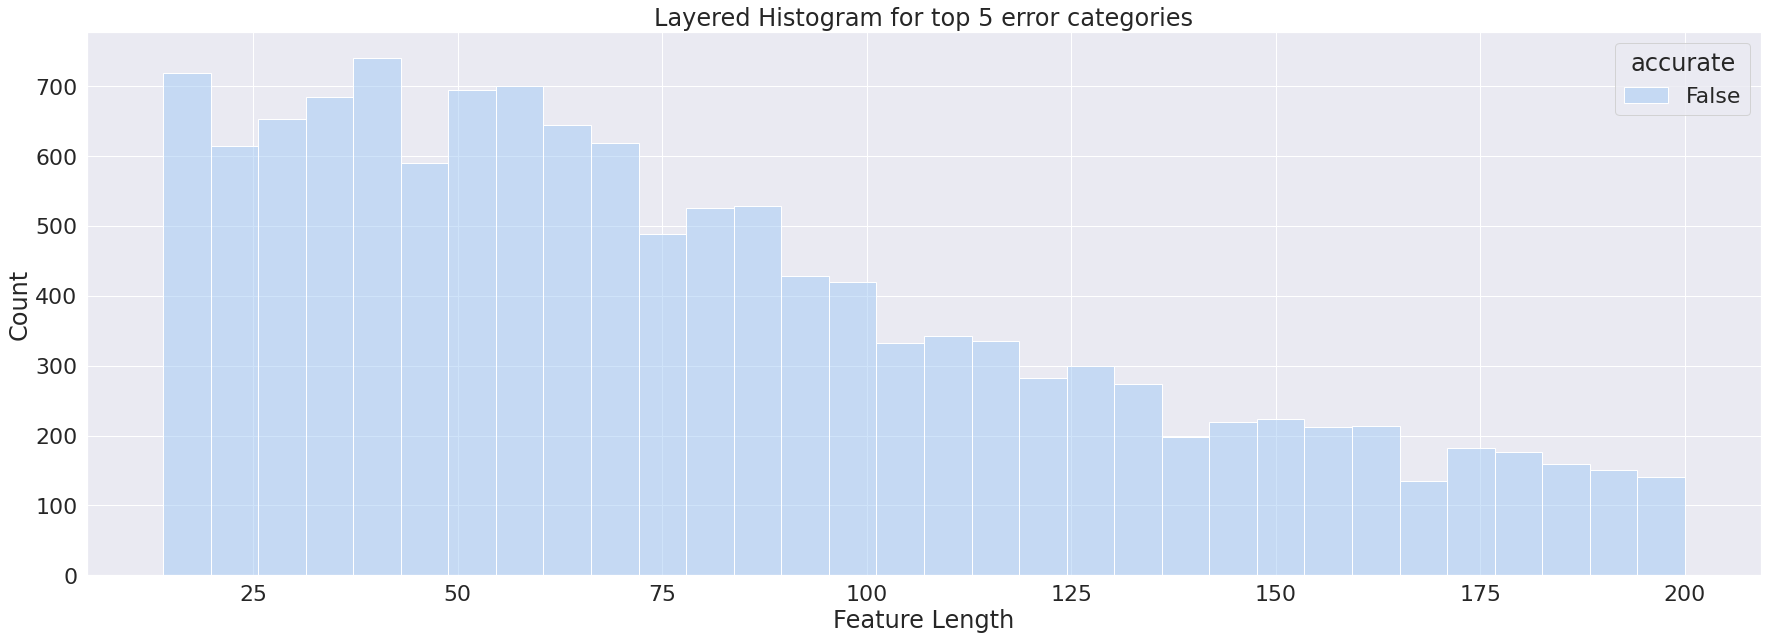

In [194]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_combined[(test_combined['MBTI Type'].isin(top_5)) & (test_combined['accurate'] == False) & (test_combined['feature_len'] <= 200) ], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")

In [173]:
#let us create a error dataframe
drill_down = test_combined[(test_combined['MBTI Type'].isin(top_5)) & (test_combined['accurate'] == False) & (test_combined['feature_len'] <= 200) ]

In [175]:
#analyze occupations
drill_down['Occupation'].value_counts()

student                                         526
self employed                                   313
servicenow sorceress                            259
retired                                         236
pantz                                           190
                                               ... 
translator                                        1
law student                                       1
architect                                         1
grad student                                      1
i make nasty tacos for a living...taco bell.      1
Name: Occupation, Length: 408, dtype: int64

In [176]:
drill_down['occu_len']=drill_down['Occupation'].str.split().str.len()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Count')

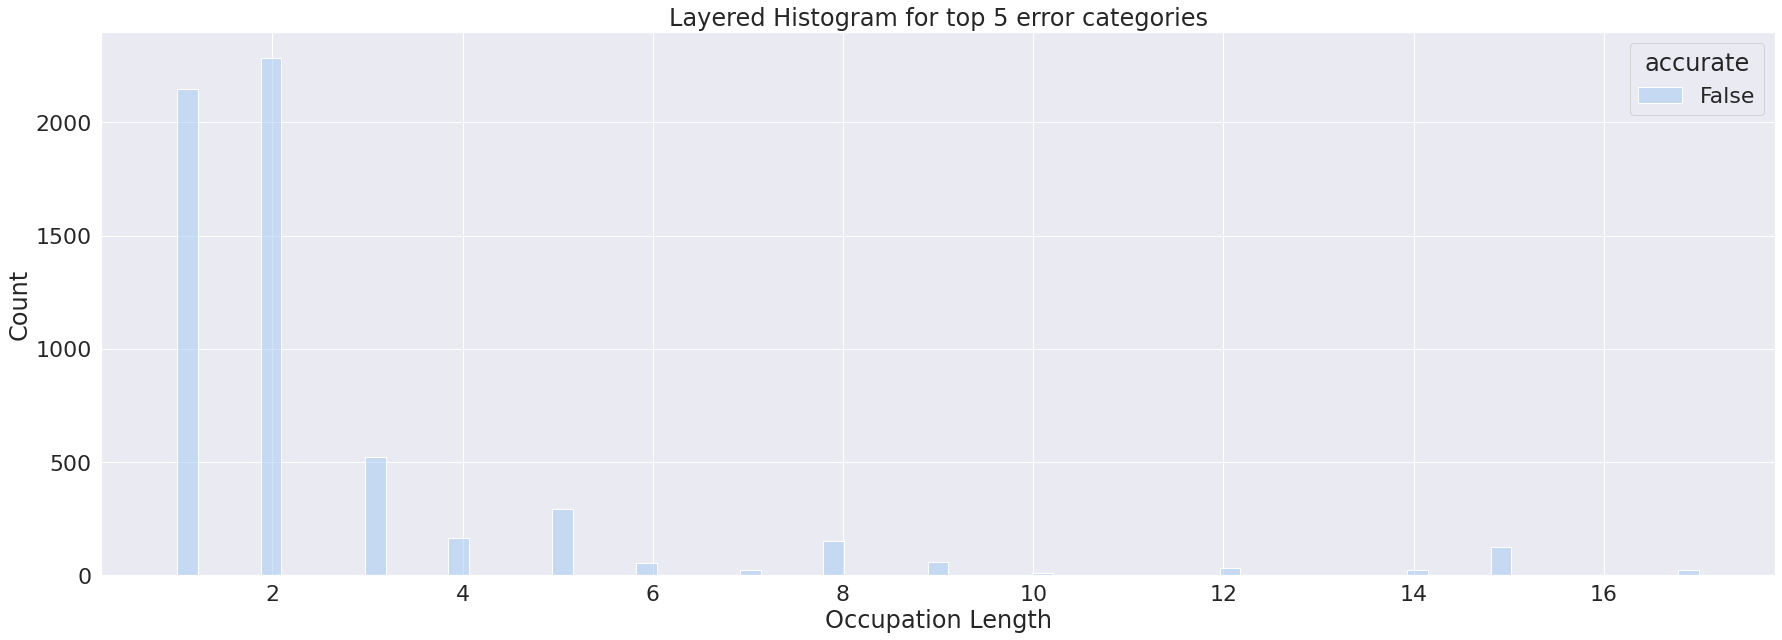

In [178]:
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=drill_down, ax=ax, stat="count", multiple="layer",
             x="occu_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Occupation Length")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

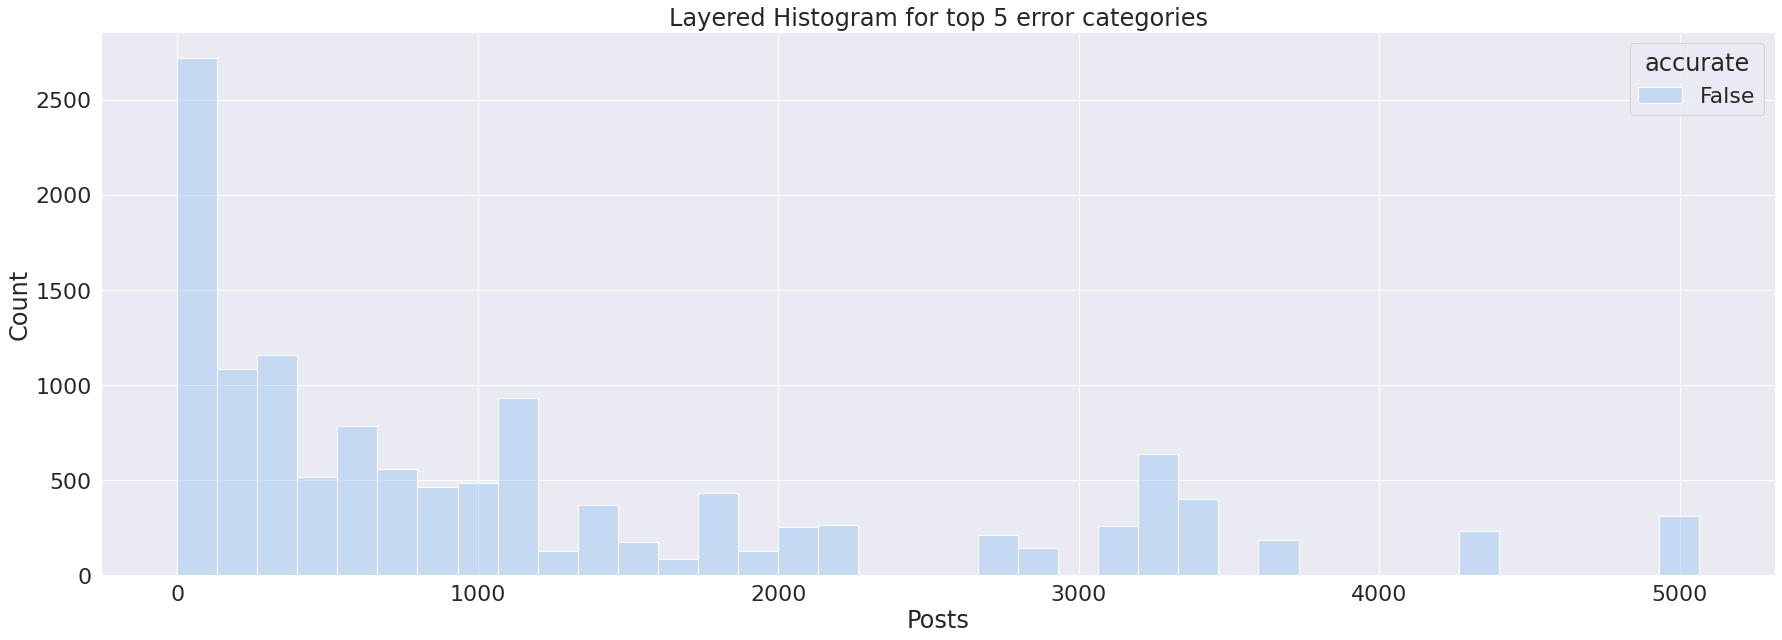

In [180]:
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=drill_down, ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

In [179]:
drill_down[drill_down['occu_len']==2]

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature,accurate,message_len,feature_len,occu_len
1400037,betty blue,45.0,5064,self employed,if you keep not making decisions like that y...,143471,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,25,62,2.0
1400146,evastover,23.0,77,freelance pianist,that is too freudian and slowmoving for my t...,442975,INFP,13,1,evastover SEP 23.0 SEP 77 SEP freelance pianis...,False,106,200,2.0
1400211,icarus,35.0,26,lawyerly adventures,random thought; did man really walk to the moo...,643783,ENTP,4,1,icarus SEP 35.0 SEP 26 SEP lawyerly adventures...,False,23,89,2.0
1400361,firebird 8118,30.0,3127,servicenow sorceress,correct: first is method/strategy and another ...,486446,INFP,13,12,firebird 8118 SEP 30.0 SEP 3127 SEP servicenow...,False,9,40,2.0
1400363,hexis,34.0,1442,us army,"that is awesome, congratulations hope everythi...",599607,ENFP,12,1,hexis SEP 34.0 SEP 1442 SEP us army SEP help 1...,False,68,174,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492904,rajah,46.0,1774,adjunct prof,my vote is for discoursus interruptus. i am ...,1096756,ENTP,4,13,rajah SEP 46.0 SEP 1774 SEP adjunct prof SEP b...,False,15,65,2.0
1492982,betty blue,45.0,5064,self employed,agreed. highly intelligent and a wonderful p...,147629,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,7,50,2.0
1492992,betty blue,45.0,5064,self employed,when you talked about things that make you ang...,146743,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,40,109,2.0
1493014,tyrinth,30.0,1154,college student.,i just noticed the mega today too after like a...,1513110,INFP,13,6,tyrinth SEP 30.0 SEP 1154 SEP college student....,False,35,117,2.0


Text(0, 0.5, 'Count')

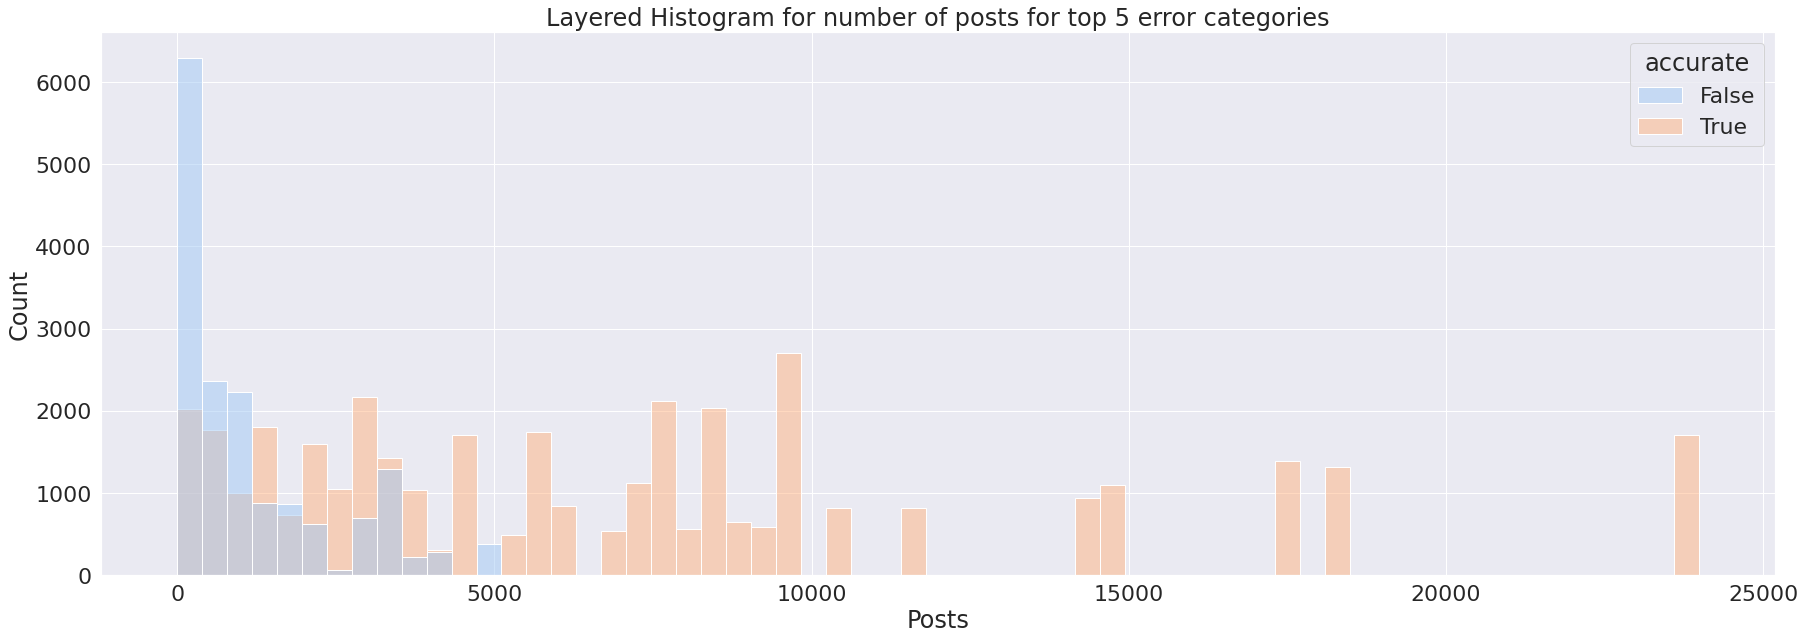

In [181]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_combined[test_combined['MBTI Type'].isin(top_5)], ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for number of posts for top 5 error categories")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

# Based on above if we have more posts from a user our ability to predict is better ,most of our errors are for Number of Posts less than 2500 posts